In [1]:
### import svg
import svg.path
from svg.path import parse_path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xml
from xml.dom import minidom
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.stats

In [3]:
def polyline2path(coord):
    
    #Transform one or more polylines svg into svg paths#
    
    for i in range(len(coord)):
        ipath=coord[i]
        ipath ="M"+ipath
        c=0
        for ichar in range(len(ipath)):
            char=ipath[ichar]
            if char == " ":
                c+=1
            if c==2:
                ipath=ipath[:ichar]+"L"+ipath[ichar:]
                break

        coord[i]=ipath

    return coord


def path2coord(path, smpl=0.001):
    
    #from svg path to coordinates#
    
    l=[]
    
    for i in np.arange(0, 1, smpl):
        l.append((path.point(i).real, -path.point(i).imag))
    
    return np.array(l)

In [4]:
doc_p = "N-S_Bumberg_only_lines-01.svg"
doc = minidom.parse(doc_p)
box=doc.getElementsByTagName('svg')[0].getAttribute("viewBox").split(" ")
ox,oy,x1,y1 = [float(i) for i in box]  # get bound box
ox, oy, x1, y1

(0.0, 0.0, 3543.58, 337.41)

In [5]:
# plt.figure(figsize=(15, 5), dpi=300)
x_length = 180
y_length = 15

dic_surfs = {}
for child in doc.childNodes[0].childNodes:
    flag = False
    try:
        ids = child.getAttribute("id")
        print(ids)
        if ids[:4] == "Rank" or ids == "Top":
            flag = True
    except:
        pass
    
    if flag:
        paths = [path.getAttribute('d') for path in child.getElementsByTagName('path')]
        transforms = [path.getAttribute('transform') for path in child.getElementsByTagName('path')]
        polylines =  [path.getAttribute('points') for path in child.getElementsByTagName('polyline')]
        path_polylines = polyline2path(polylines)

        new_l=[]
        for i_a, transf in zip(paths, transforms):
            
            coord = path2coord(parse_path(i_a), smpl=0.01)
            
            if len(transf) > 0:
            
                x_t, y_t = transf.split("(")[-1].split(")")[0].split()
                x_t = float(x_t)
                y_t = float(y_t)

                coord[:, 0] -= x_t
                coord[:, 1] -= y_t

            new_l.append(coord)
            
        for i_a in path_polylines:
            new_l.append(path2coord(parse_path(i_a), smpl=0.01))
        
        #change coordinates in meters
        fac_x=x1/x_length
        min_y=y1
        for line in new_l:
            line[:, 0]/=fac_x
            line[:, 1]+=min_y

        fac_y=y1/y_length
        for line in new_l:
            line[:, 1]/=fac_y
        

        dic_surfs[ids] = new_l




Rank_3
Rank_4
Rank_5
Rank_7
Top


In [6]:
d_color = {"Rank_3" : "darkorange",
           "Rank_4" : "fuchsia",
           "Rank_5" : "blue",
           "Rank_7" : "red",
           "Top"    : "black"}

(-8.971960559660006, 188.9699287161571, -0.6984565240248386, 15.72489935036524)

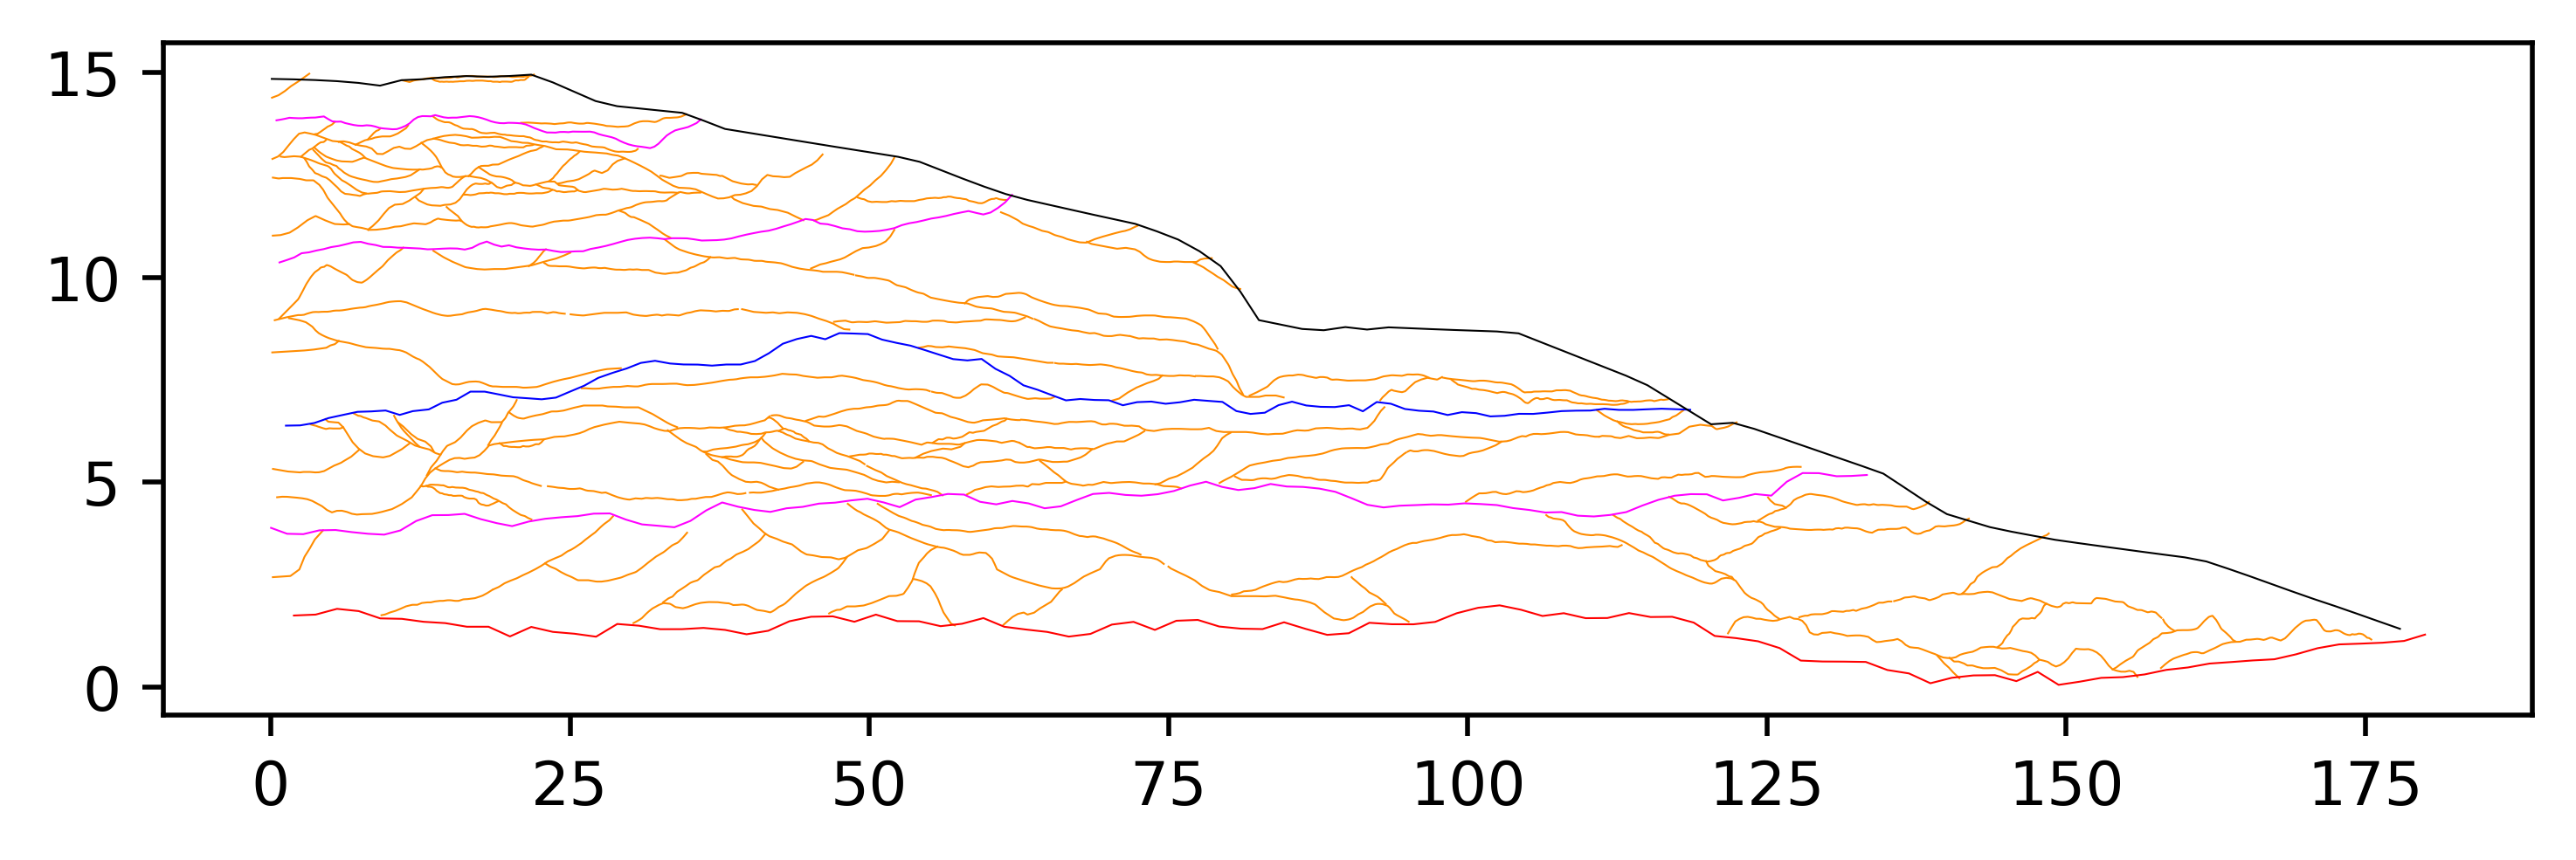

In [7]:
plt.figure(figsize=(7, 2), dpi=500)

for k,v in dic_surfs.items():
    
    for test in v:
        plt.plot(test[:, 0], test[:, 1], linewidth=.3, c=d_color[k])
    
plt.axis("auto")

### estimate variogram exp

In [8]:
import geone

In [9]:
cm_test = geone.covModel.CovModel1D(elem=[("spherical", {"w":np.nan, "r":np.nan}),
                                         ("cubic", {"w":np.nan, "r":np.nan}),
                                         ("exponential", {"w":np.nan, "r":np.nan})])

# cm_test = geone.covModel.CovModel1D(elem=[("matern", {"w":np.nan, "r":np.nan, "nu":np.nan})])

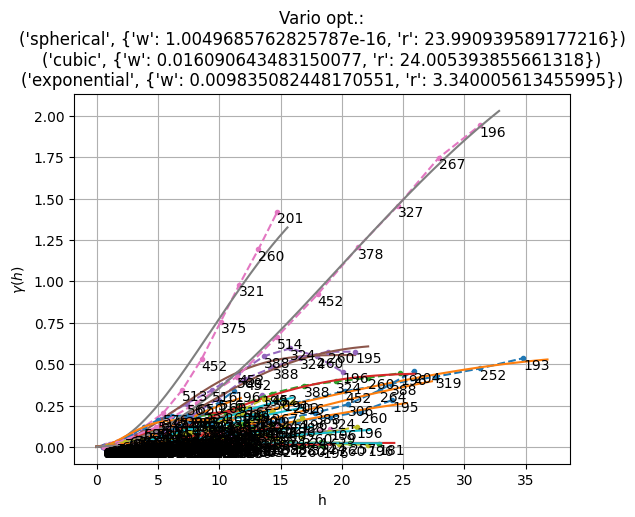

In [10]:

x = []
val = []

h_l = []
v_l = []
p_l = []

cm_l = []
popt = []
plot = True

means = []
for iv in dic_surfs["Rank_3"][:]:
    
    xmax = np.max(iv[:, 0])
    xmin = np.min(iv[:, 0])
    hmax = 0.8* (xmax - xmin)
#     hmax = 0.8* (iv[:, 0][0] - iv[:, 0][-1])
    
    mean = np.mean(iv[:, 1])
    
    if hmax > 10:
        
        means.append(mean)
        
        h,v,p = geone.covModel.variogramExp1D(iv[:, 0], iv[:, 1], make_plot=plot, hmax=hmax)
        
        var = 3
        if not np.isnan(h).any():
            try:
#                 cm_opt = geone.covModel.covModel1D_fit(iv[:, 0], iv[:, 1], cm_test, bounds=((0, 0, 0), 
#                                                                             (var, 2*hmax, 5)),
#                                     p0=(1, 10, 1), hmax=hmax, make_plot=plot)
                cm_opt = geone.covModel.covModel1D_fit(iv[:, 0], iv[:, 1], cm_test, bounds=((0, 0, 0, 0, 0, 0), 
                                                                                            (var, 2*hmax, var, 2*hmax, var, 2*hmax)),
                                                    p0=(1, 10, 1, 10, 1, 10), hmax=hmax, make_plot=plot)
            except:
                cm_opt = None

            if cm_opt is not None:

                cm = cm_opt[0]
                for elem in cm.elem:
                    if elem[1]["w"] < 0.1:
                        cm.elem.remove(elem)
                
                if len(cm.elem) > 0:
                    cm_l.append(cm)
                    popt.append(cm_opt[1])
                    
                    h_l.append(h)
                    v_l.append(v)
                    p_l.append(p)


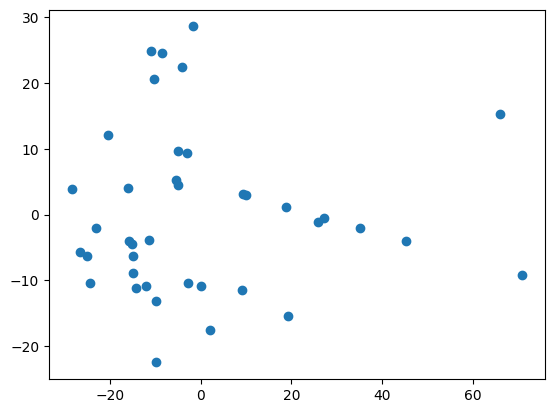

In [11]:
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

X = np.array(popt)
pca = PCA(n_components=2)
res = pca.fit_transform(X)
#kmeans = KMeans(n_clusters=3, random_state=1, n_init="auto").fit(res)

plt.scatter(res[:, 0], res[:, 1])

In [12]:
Cp = (np.cov(np.array(popt).T))
mu = np.mean(popt, axis=0)

In [13]:
np.random.multivariate_normal(mu, Cp)

array([7.93227039e-02, 4.13640617e+01, 3.00563004e-01, 6.41247612e+01,
       8.44799219e-03, 3.86810189e+01])

In [14]:

# for i in range(100):

#     w, r, nu = np.random.multivariate_normal(mu, Cp)
#     if w > 0 and r > 0 and nu > 0:
#         cm_plot = geone.covModel.CovModel1D(elem=[("matern", {"w":w, "r":r, "nu":nu})])
#         cm_plot.plot_model(1)

In [15]:
popt = np.array(popt)

In [16]:
# simple mean
mean_popt = popt.mean(0)

# weighted (by length) mean

weights = np.array(h_l)[:, -1] - np.array(h_l)[:, 0]
mean_popt = (weights.reshape(-1, 1) * popt).sum(0) / weights.sum()

In [17]:
cm_mean_popt = geone.covModel.CovModel1D(elem=[("spherical", {"w":mean_popt[0], "r":mean_popt[1]}),
                                         ("cubic", {"w":mean_popt[2], "r":mean_popt[3]}),
                                         ("exponential", {"w":mean_popt[4], "r":mean_popt[5]})])

# cm_mean_popt = geone.covModel.CovModel1D(elem=[("matern", {"w":mean_popt[0], "r":mean_popt[1], "nu":mean_popt[2]})])


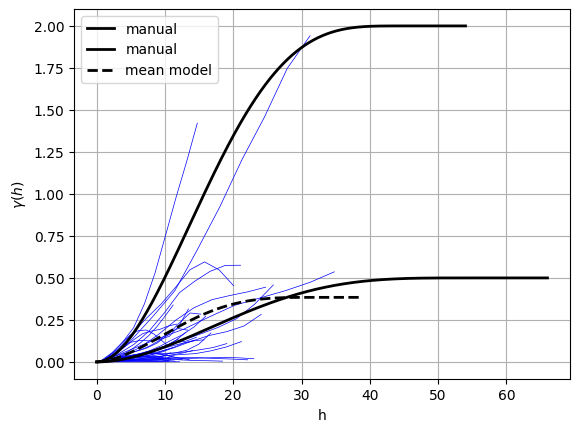

In [18]:
for h, v in zip(h_l, v_l):
    plt.plot(h, v, c="blue", linewidth=.5)
    
cm_r3_manual1 = geone.covModel.CovModel1D(elem=[("cubic", {"w":.5, "r":55})])
cm_r3_manual1.plot_model(1, c="k", linewidth=2, label="manual")

cm_r3_manual2 = geone.covModel.CovModel1D(elem=[("cubic", {"w":2, "r":45})])
cm_r3_manual2.plot_model(1, c="k", linewidth=2, label="manual")

cm_mean_popt.plot_model(1, c="k", linewidth=2, linestyle="--", label="mean model")
plt.legend()

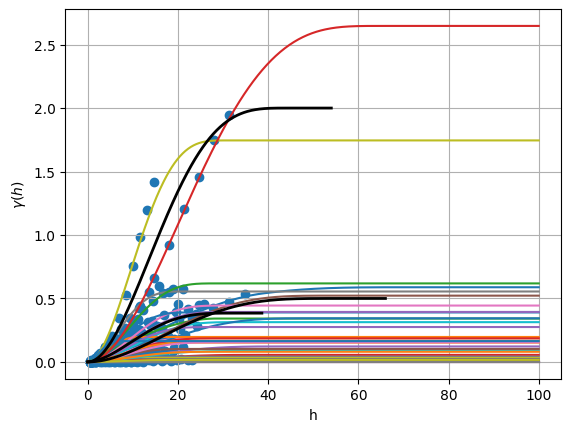

In [19]:
for cm in cm_l:
    cm.plot_model(1, hmax=100)
    
plt.scatter(h_l, v_l)
cm_mean_popt.plot_model(1, c="k", linewidth=2)

cm_r3_manual1.plot_model(1, c="k", linewidth=2, label="manual")
cm_r3_manual2.plot_model(1, c="k", linewidth=2, label="manual")

(0.0, 17.0)

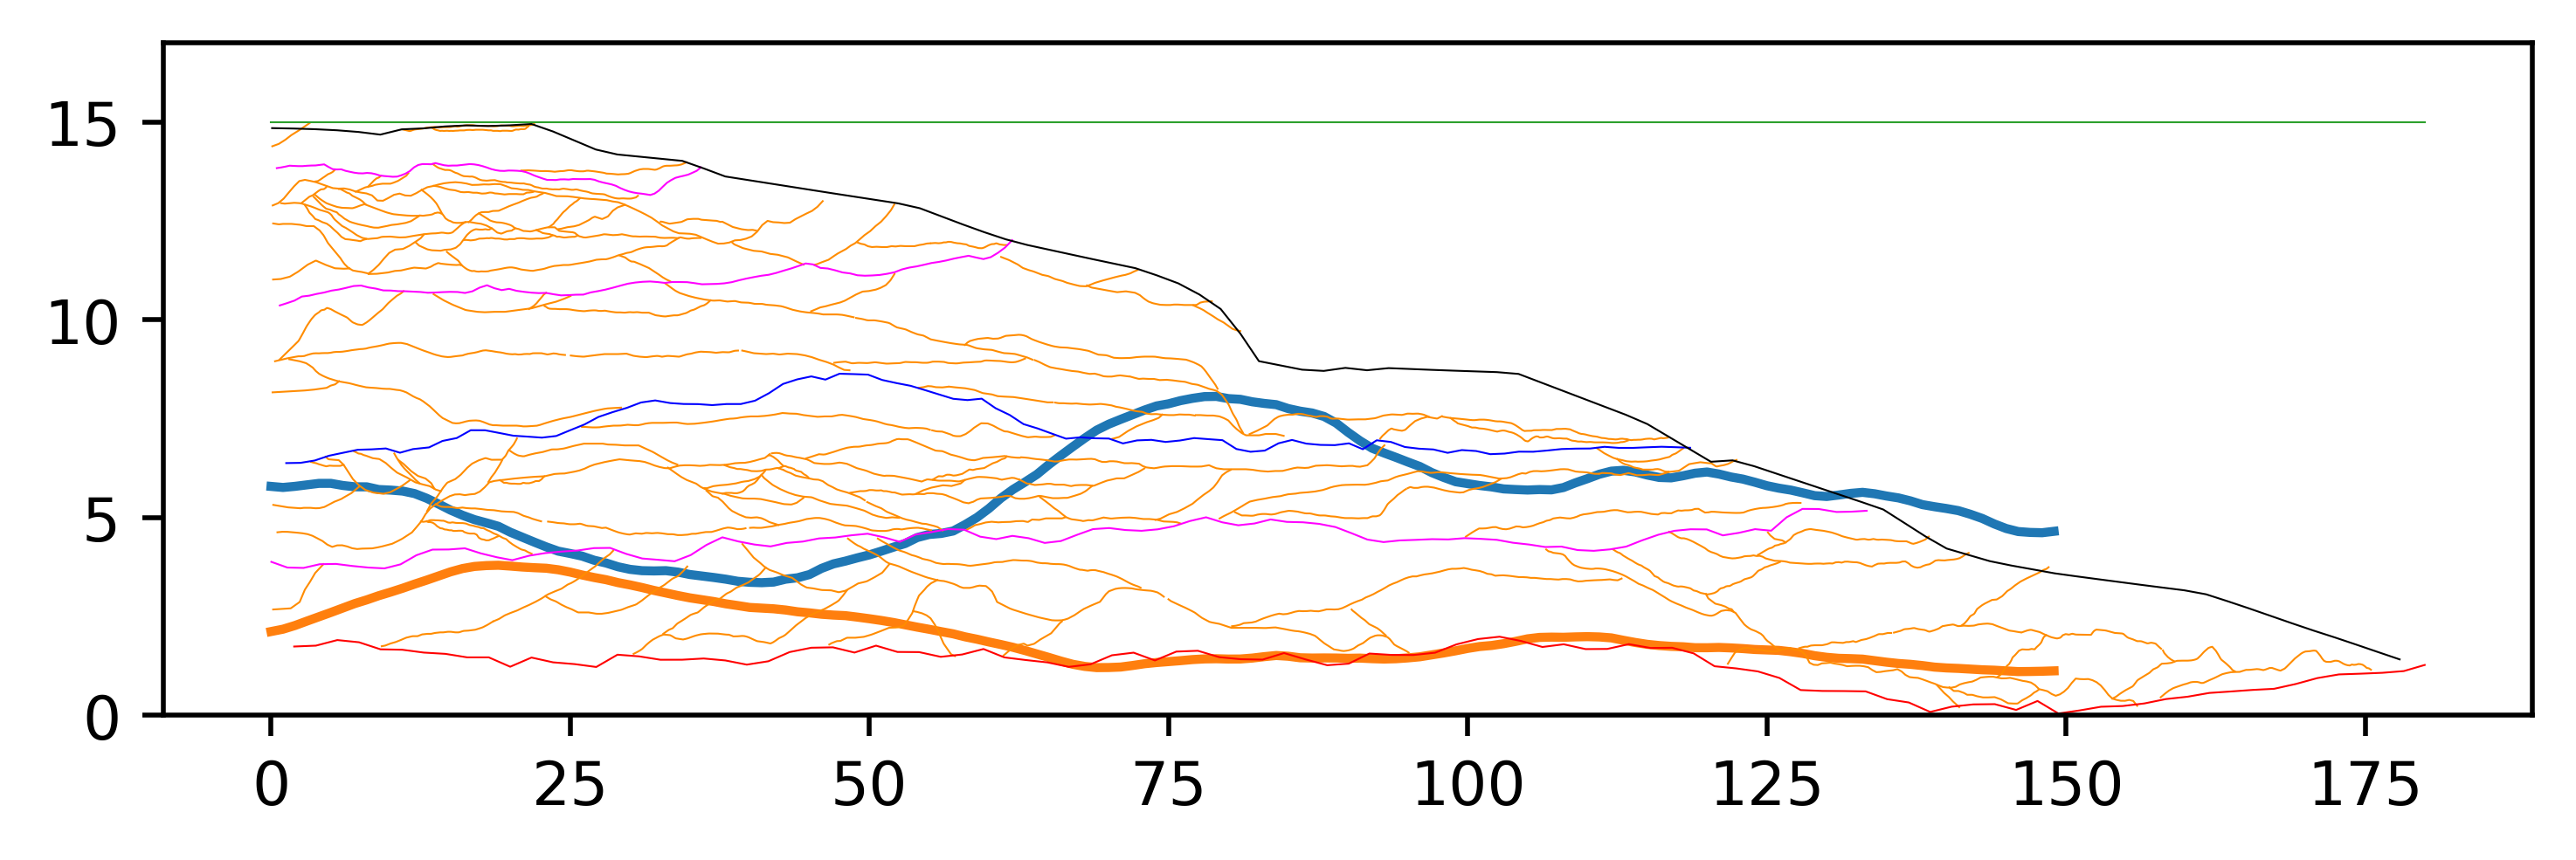

In [20]:
plt.figure(figsize=(7, 2), dpi=500)

cm = np.random.choice(cm_l)
sim = geone.multiGaussian.multiGaussianRun(cm_r3_manual2, 150, 1, output_mode="array", mean=5)
plt.plot(sim[0])

sim = geone.multiGaussian.multiGaussianRun(cm_r3_manual1, 150, 1, output_mode="array", mean=2)
plt.plot(sim[0])

for k,v in dic_surfs.items():
    
    for test in v:
        plt.plot(test[:, 0], test[:, 1], linewidth=.3, c=d_color[k])
plt.plot((ox, x_length), (y_length, y_length), linewidth=.3)

plt.ylim(0, 17)

### Covmodels rank 5-7

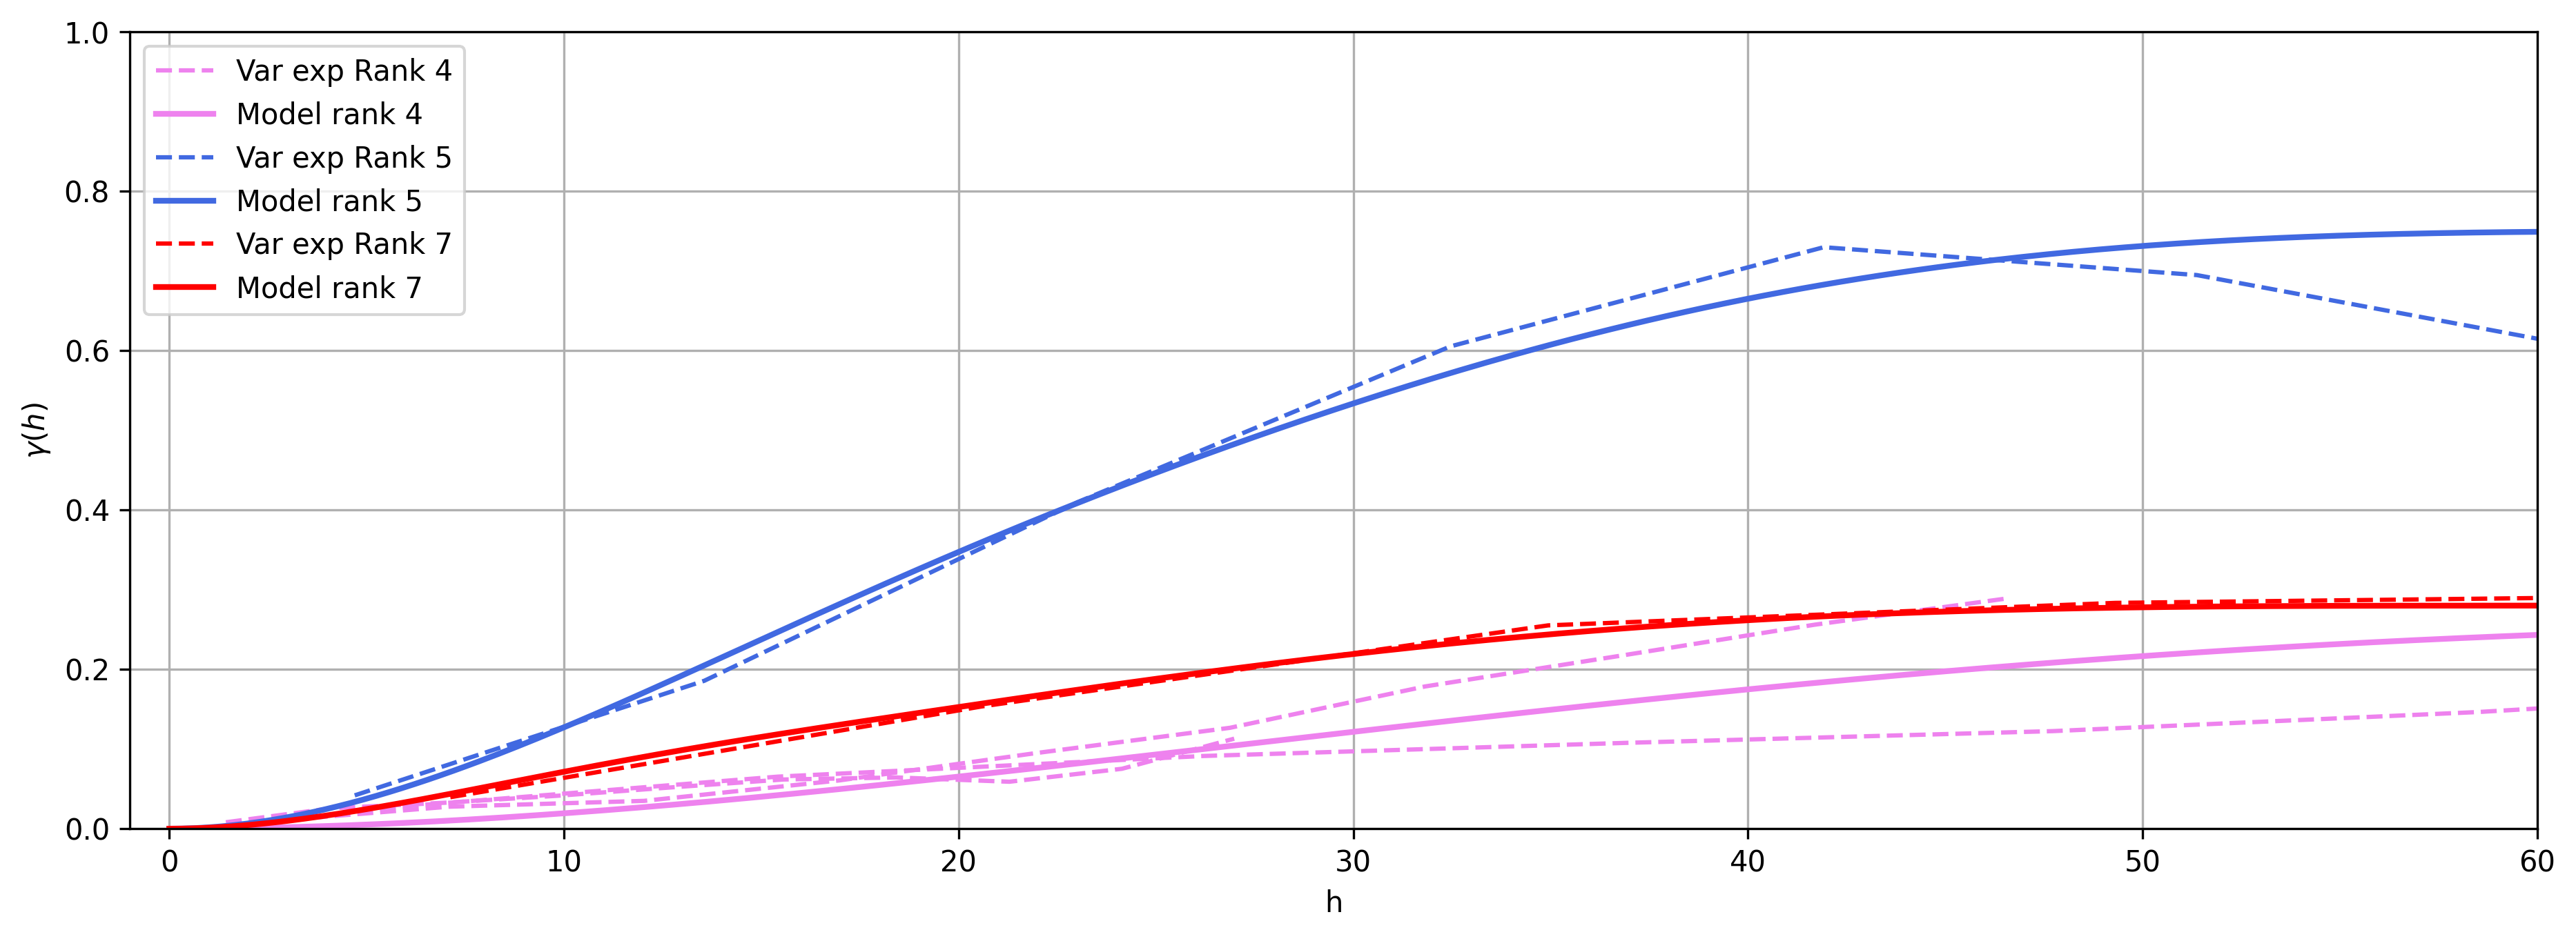

In [21]:
fig = plt.figure(figsize=(15, 5), dpi=300)
x = []
val = []

i = 0
for iv in dic_surfs["Rank_4"]:
    
    hmax = 0.8 * np.abs(iv[-1, 0] - iv[0, 0])
    h, v, pt = geone.covModel.variogramExp1D(iv[:, 0], iv[:, 1], hmax= hmax, make_plot=False)
    
    if i == 0:
        plt.plot(h, v, linestyle="--", label="Var exp Rank 4", c="violet")
    else:
        plt.plot(h, v, linestyle="--", c="violet")
    i += 1
    
    cm_r4 = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.26, "r":90}),
                                              ("spherical", {"w":0., "r":80})])
    
cm_r4.plot_model(1, c = "violet", linewidth="2", label="Model rank 4")


for iv in dic_surfs["Rank_5"]:
    
    hmax = 0.8 * np.abs(iv[-1, 0] - iv[0, 0])
    h, v, pt = geone.covModel.variogramExp1D(iv[:, 0], iv[:, 1], hmax=hmax, make_plot=False)
    plt.plot(h, v, linestyle="--", label="Var exp Rank 5", c="royalblue")
    cm_r5 = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.65, "r":68}),
                                              ("cubic", {"w":0.1, "r":30})])
    
cm_r5.plot_model(1, c = "royalblue", linewidth="2", label="Model rank 5")
    
for iv in dic_surfs["Rank_7"]:
    
    hmax = 0.8 * np.abs(iv[-1, 0] - iv[0, 0])
    h, v, pt = geone.covModel.variogramExp1D(iv[:, 0], iv[:, 1], hmax=hmax, make_plot=False)
    plt.plot(h, v, linestyle="--", label="Var exp Rank 7", c="red")
    cm_r7 = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.23, "r":62}),
                                              ("cubic", {"w":0.05, "r":20})])
    
cm_r7.plot_model(1, c = "red", linewidth="2", label="Model rank 7")


# # rank 3
# i = 0
# for h, v in zip(h_l, v_l):
    
#     if i == 0:
#         plt.plot(h, v, c="goldenrod", linestyle="--", label = "Var exp Rank 3", alpha = .5)
#     else:
#         plt.plot(h, v, c="goldenrod", linestyle="--", alpha = .5)
#     i += 1
# cm_r3_manual1.plot_model(1, c="goldenrod", linewidth=2, label="Model rank 3 - 1")
# cm_r3_manual2.plot_model(1, c="goldenrod", linewidth=2, label="Model rank 3 - 2")
# cm_mean_popt.plot_model(1, c="chocolate", linewidth=2, label="Model rank 3 (mean popt)")

plt.xlim(-1, 60)
plt.ylim(0, 1)
a = plt.legend()

### Colors, probas, facies ids

In [25]:
im =  geone.img.readImage2Drgb("Artboard 1.png", categ=True)

In [26]:
d_replace = {640: 843, 790:843, 2:74}
for k, v in d_replace.items():
    im[0].val[im[0].val == k] = v

In [27]:
bn_counts = np.bincount(im[0].val.flatten().astype(int))
idx = np.arange(len(bn_counts))

d = {}
for bn, id in zip(bn_counts, idx):
    d[id] = bn
    
n_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

c_idx = list(n_d.keys())[-4:-1]
d = {k: v for k, v in n_d.items() if k in c_idx}  # keep real facies

facies_ids = list(d.keys())

colors = {v: im[1][v] for v in c_idx}

# proportions
tot_sum = sum(d.values())
probas = []
for k, v in d.items():
    probas.append(v / tot_sum)

In [28]:
colors

{74: array([0.2, 0.6, 0. , 1. ], dtype=float32),
 332: array([0.4, 0.6, 1. , 1. ], dtype=float32),
 843: array([1. , 0.8, 0.2, 1. ], dtype=float32)}

In [29]:
im[0].set_spacing(180/im[0].nx, 15/im[0].ny, 1)
im[0].val[~np.isin(im[0].val, facies_ids)] = np.nan

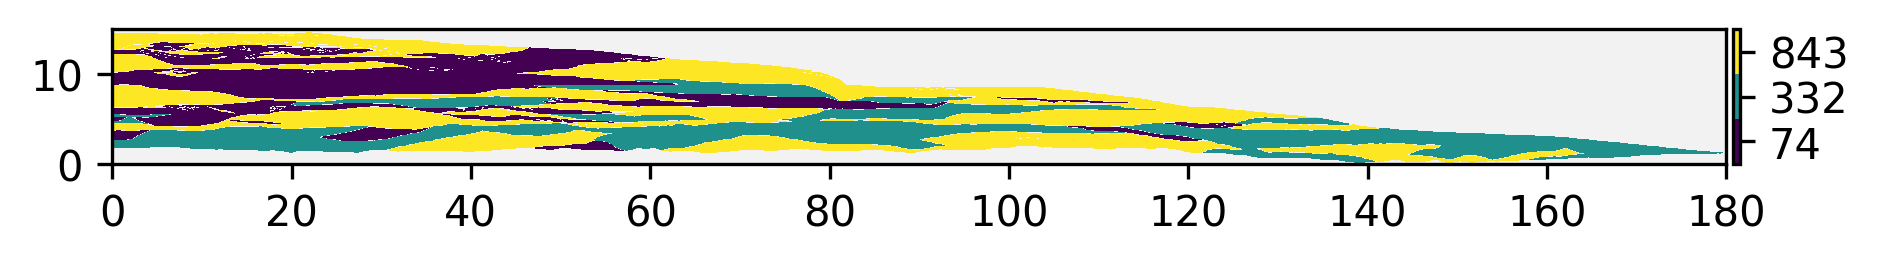

In [30]:
plt.figure(figsize=(7, 2), dpi=300)
geone.imgplot.drawImage2D(im[0], categ=True, origin="lower")

In [31]:
colors

{74: array([0.2, 0.6, 0. , 1. ], dtype=float32),
 332: array([0.4, 0.6, 1. , 1. ], dtype=float32),
 843: array([1. , 0.8, 0.2, 1. ], dtype=float32)}

In [32]:
im[0]

*** Img object ***
name = ''
(nx, ny, nz) = (3546, 345, 1) # number of cells along each axis
(sx, sy, sz) = (0.050761421319796954, 0.043478260869565216, 1.0) # cell size (spacing) along each axis
(ox, oy, oz) = (0.0, 0.0, 0.0) # origin (coordinates of bottom-lower-left corner)
nv = 1  # number of variable(s)
varname = ['code']
val: (1, 1, 345, 3546)-array
*****

In [33]:
im_new_2 = im[0]

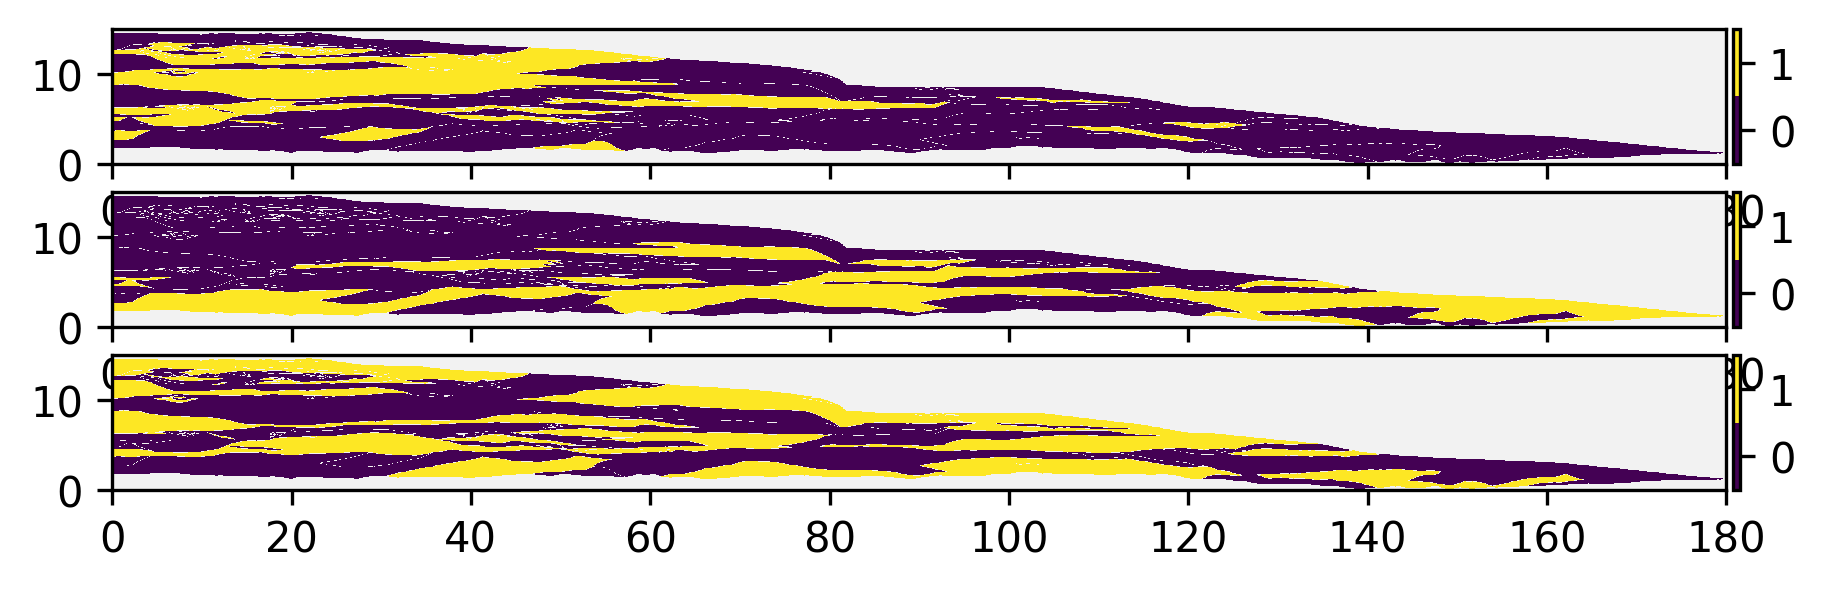

In [34]:
# create a binary image for each facies
im_bin = []
for i in range(len(facies_ids)):
    val = (im_new_2.val==facies_ids[i]).astype(float)
    # set nan where there is nan in the image
    val[im_new_2.val != im_new_2.val] = np.nan
    im_bin.append(geone.img.Img(nx=im_new_2.nx, ny=im_new_2.ny, nz=1, nv=1, val=val,
                                sx = im_new_2.sx, sy=im_new_2.sy, sz=im_new_2.sz,
                                ox=im_new_2.ox, oy=im_new_2.oy, oz=im_new_2.oz,
                                name="facies_"+str(facies_ids[i])))
    
# plots
plt.figure(figsize=(7, 2), dpi=300)
o = 1
for im_i in im_bin:
    plt.subplot(3, 1, o)
    geone.imgplot.drawImage2D(im_i, categ=True, origin="lower")
    o += 1

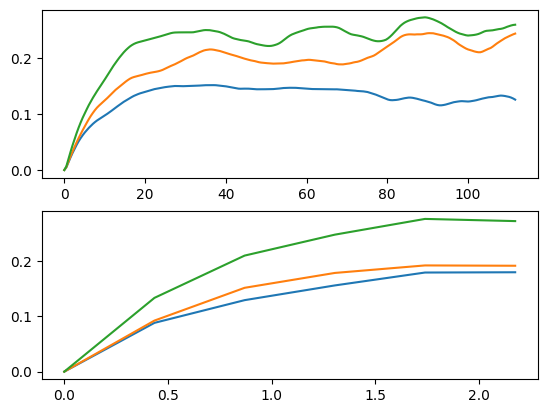

In [35]:
o = 0
varios_hor = []
varios_ver = []

for im_i in im_bin[:]:
    im_bin_1_cov = geone.geosclassicinterface.imgTwoPointStatisticsImage(im_i, 0, hx_min=-2200, hx_max=2200, hy_min=-50, hy_max=50, hx_step=10, hy_step=10, stat_type="variogram")
    x = im_bin_1_cov.sx * np.arange(int(im_bin_1_cov.nx/2 + 1))
    y = im_bin_1_cov.sy * np.arange(int(im_bin_1_cov.ny/2 + 1))
    varios_hor.append((x, im_bin_1_cov.val[0, 0, int(im_bin_1_cov.ny/2), int(im_bin_1_cov.nx/2):]))
    varios_ver.append((y, im_bin_1_cov.val[0, 0, int(im_bin_1_cov.ny/2):, int(im_bin_1_cov.nx/2)]))
    
    plt.subplot(2, 1, 1)
    plt.plot(x, im_bin_1_cov.val[0, 0, int(im_bin_1_cov.ny/2), int(im_bin_1_cov.nx/2):])

    plt.subplot(2, 1, 2)
    plt.plot(y, im_bin_1_cov.val[0, 0, int(im_bin_1_cov.ny/2):, int(im_bin_1_cov.nx/2)])

    var_fa = probas[o] * (1 - probas[o]) 
    # plt.scatter((0, max(x)), (var_fa, var_fa), c="k", alpha=0.3)
    o += 1

# plt.xlim(0, 20)

In [36]:
probas

[0.2574111939935487, 0.3153001128893466, 0.42728869311710466]

In [37]:
colors

{74: array([0.2, 0.6, 0. , 1. ], dtype=float32),
 332: array([0.4, 0.6, 1. , 1. ], dtype=float32),
 843: array([1. , 0.8, 0.2, 1. ], dtype=float32)}

(-1.0, 1.0)

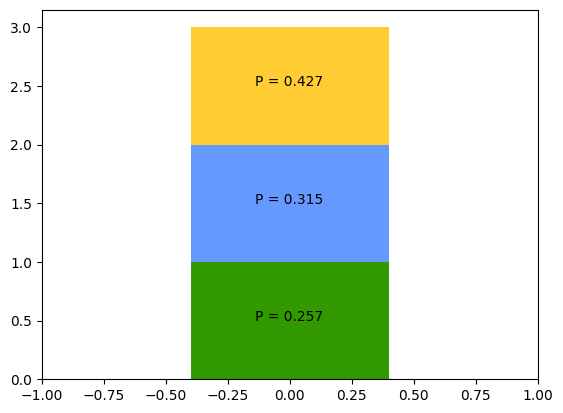

In [38]:
for i in range(len(colors)):
    color = list(colors.values())[i]
    plt.bar(0, 1, bottom=i, color=color)
    plt.text(-0.14, i+0.5, "P = " + str(np.round(probas[i], 3)))
plt.xlim(-1, 1)

In [39]:
import sys

sys.path.append("../../")

In [40]:
import EROS

In [41]:
#number of surf
N = 50

# grid
oz = 0
z1 = 16
ox = 0
x1 = 175
nx = 300
nz = 200
sx = 175 / nx
sz = 16 / nz
xg = np.linspace(0, 175, nx)
zg = np.linspace(0, 16, nz)

means = np.sort(np.random.uniform(0, 15, size=N))

# bot 
x_bot, z_bot = dic_surfs["Rank_7"][0].T
bot = np.interp(xg, x_bot[::-1], z_bot[::-1])

# top 
x_top, z_top = dic_surfs["Top"][0].T
top = np.interp(xg, x_top, z_top)

In [42]:
covmodels = np.random.choice([cm_r3_manual1, cm_r3_manual2, cm_mean_popt], size=N, p = (0.2, 0.2, 0.6))

In [43]:
# cm_mean_popt.elem.pop(2)

In [44]:
real_surf, arr_res, list_p_cond = EROS.sim_uncond_2D(N, cm_mean_popt, means, (nx, nz), (sx, sz), (0, 0),
                                                     bot = bot, top = top, xi = 0.2, facies_ids=facies_ids, proba=probas,
                                                     alpha=.7, seed=None, grf_method="sgs")

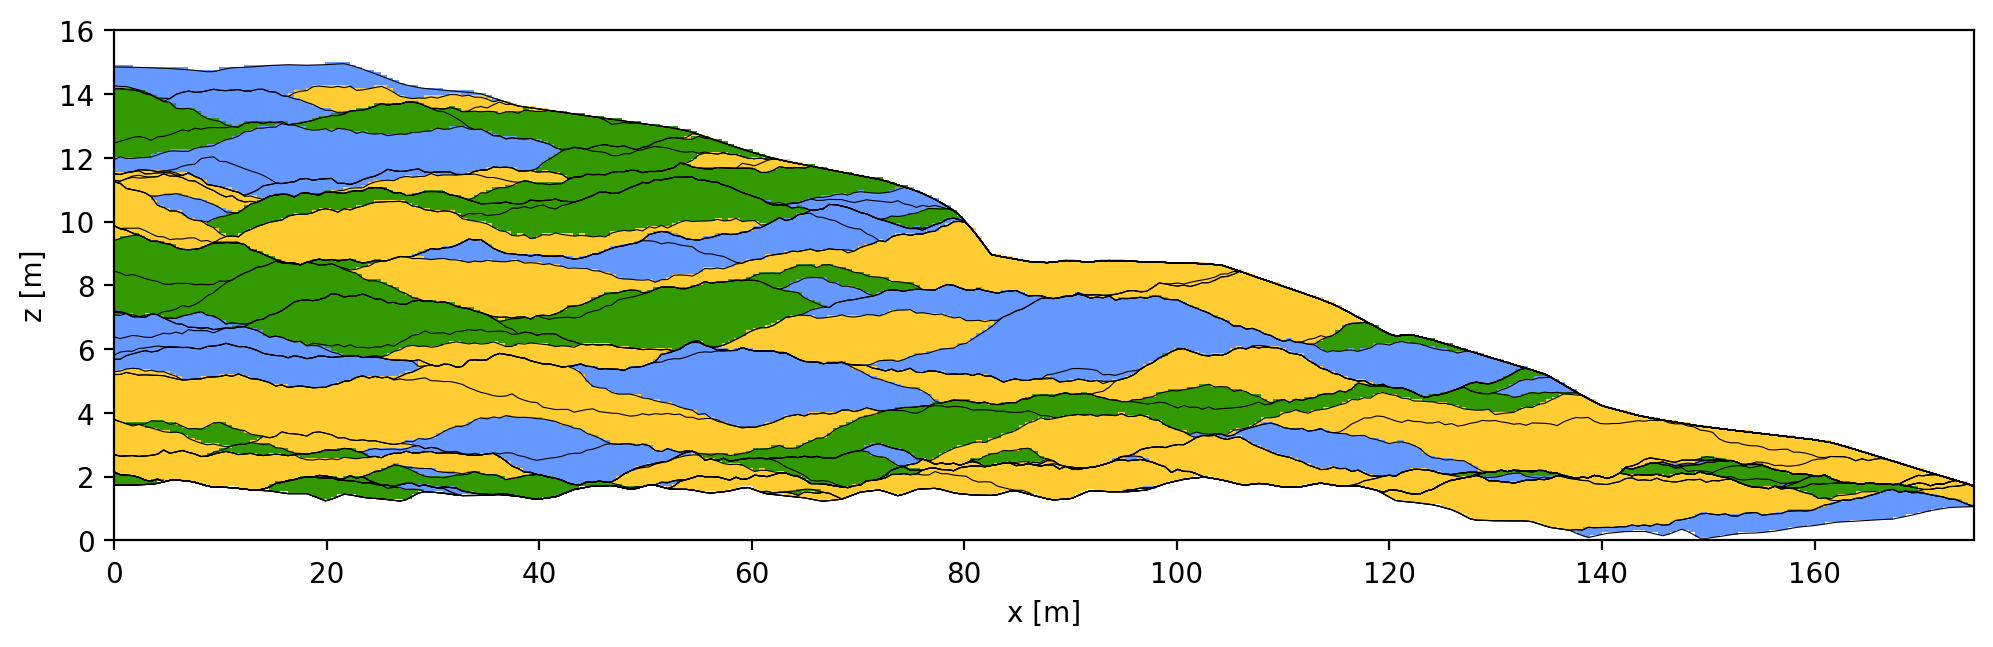

In [45]:
arr_plot = np.zeros([nz, nx, 3])
o = 0
for ival in np.unique(arr_res):
    if ival == -99:
        arr_plot[arr_res==-99] = (1, 1, 1)
#     else:
#         np.random.seed(ival+24)
#         arr_plot[arr_res==ival] = np.random.random(size=3)
    else:
        arr_plot[arr_res==ival] = colors[ival][:3]
    
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=1, aspect=3)
plt.plot(xg, real_surf.T, c="k", linewidth=.4)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.show()

# Reference

In [46]:
{640: np.array([0.8, 0.2, 0.6, 1. ], dtype=float),
 790: np.array([1. , 0.4, 0. , 1. ], dtype=float),
 2: np.array([0.2, 0.4, 0. , 1. ], dtype=float),
 74: np.array([0.2, 0.4, 0. , 1. ], dtype=float),
 332: np.array([0.4, 0.6, 1. , 1. ], dtype=float),
 843: np.array([1. , 0.8, 0.2, 1. ], dtype=float)}

{640: array([0.8, 0.2, 0.6, 1. ]),
 790: array([1. , 0.4, 0. , 1. ]),
 2: array([0.2, 0.4, 0. , 1. ]),
 74: array([0.2, 0.4, 0. , 1. ]),
 332: array([0.4, 0.6, 1. , 1. ]),
 843: array([1. , 0.8, 0.2, 1. ])}

In [47]:
colors

{74: array([0.2, 0.6, 0. , 1. ], dtype=float32),
 332: array([0.4, 0.6, 1. , 1. ], dtype=float32),
 843: array([1. , 0.8, 0.2, 1. ], dtype=float32)}

In [48]:
arr_color = plt.imread("S-N_Bumberg_only_facies.png")

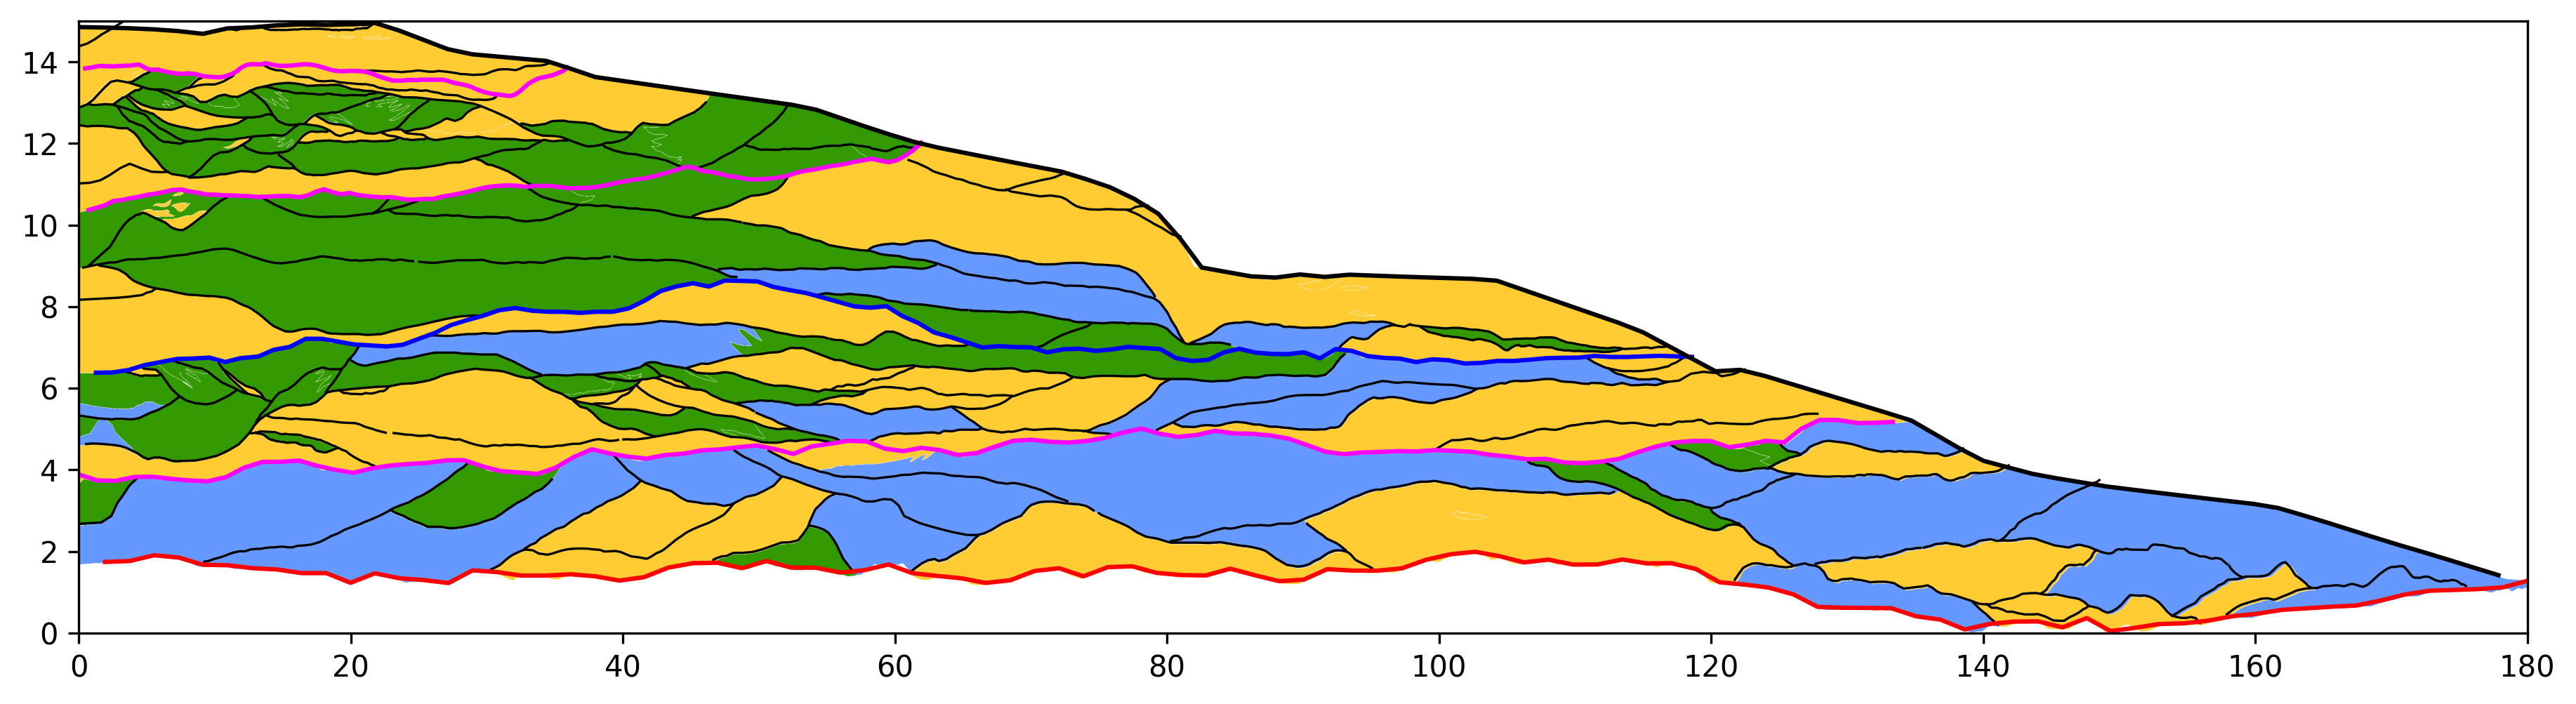

In [49]:
plt.figure(figsize=(15, 5), dpi=300)
arr_color = plt.imread("S-N_Bumberg_only_facies.png")

arr_plot_ref = np.ones(arr_color.shape)
# keep colors
for c in colors.values():
    arr_plot_ref[(arr_color==c).all(2), :] = c

arr_plot_ref[(arr_color==np.array([0.2, 0.4, 0. , 1. ], dtype=np.float32)).all(2), :] = [0.2, 0.6, 0. , 1. ]
arr_plot_ref[(arr_color==np.array([1. , 0.4, 0. , 1. ], dtype=np.float32)).all(2), :] = [1. , 0.8, 0.2, 1. ]
arr_plot_ref[(arr_color==np.array([0.8, 0.2, 0.6, 1. ], dtype=np.float32)).all(2), :] = [1. , 0.8, 0.2, 1. ]

plt.imshow(arr_plot_ref, extent=[0, 180, 0, 15], aspect=3)

for k,v in dic_surfs.items():
    if k == "Rank_3":
        for test in v:
            plt.plot(test[:, 0], test[:, 1], linewidth=.8, c="k")
    else:
        for test in v:
            plt.plot(test[:, 0], test[:, 1], linewidth=1.5, c=d_color[k])

In [50]:
## boreholes

n = 3
x = np.random.random(size=3) * x1
bh_idxs = np.round((x - ox) / sx).astype(int)
logs = im[0].val[0, 0, :, bh_idxs]

In [51]:
for log in logs:
    l = []
    for s in log:
        if s in facies_ids:
            l.append(s)

In [52]:
l

[332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 332.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 843.0,
 843.0,
 843.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 74.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.0,
 843.

### Multiple levels

In [53]:
cm_test = geone.covModel.CovModel1D(elem=[("cubic", {"w":np.nan, "r":np.nan}),
                                          ("cubic", {"w":np.nan, "r":np.nan})])

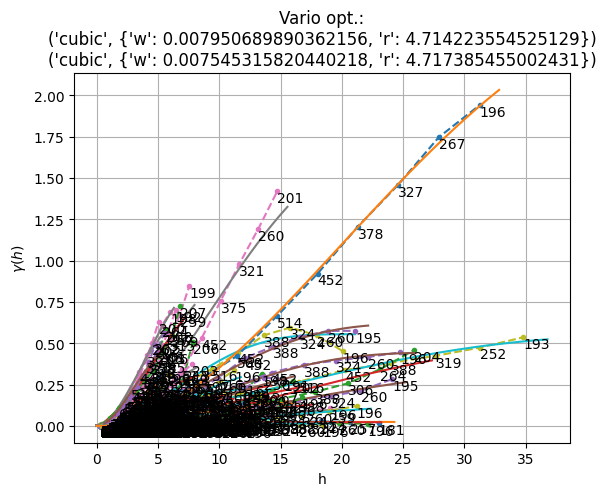

In [54]:
## covmodels

x = []
val = []

h_l = []
v_l = []
p_l = []

cm_l = []
popt = []
plot = True
groups = []

means = []
for iv in dic_surfs["Rank_3"][:]:
    
    ## detect in which group is the line
    c = 0  # counter --> indicates the hierarchical group of the line
    p = iv[int(len(iv[:, 0])/2)]
    for s in dic_surfs["Rank_4"] + dic_surfs["Rank_5"]:
        if p[1] > (np.interp(p[0], s[:, 0], s[:, 1])):
            c += 1
    
    xmax = np.max(iv[:, 0])
    xmin = np.min(iv[:, 0])
    hmax = 0.8* (xmax - xmin)
    
    mean = np.mean(iv[:, 1])
    if hmax > 5:
        
        means.append(mean)
        
        h,v,p = geone.covModel.variogramExp1D(iv[:, 0], iv[:, 1], make_plot=plot, hmax=hmax)
        
        var = 3
        if not np.isnan(h).any():
            try:
#                 cm_opt = geone.covModel.covModel1D_fit(iv[:, 0], iv[:, 1], cm_test, bounds=((0, 0, 0), 
#                                                                             (var, 2*hmax, 5)),
#                                     p0=(1, 10, 1), hmax=hmax, make_plot=plot)
                cm_opt = geone.covModel.covModel1D_fit(iv[:, 0], iv[:, 1], cm_test, bounds=((0, 0, 0, 0), 
                                                                                            (var, 2*hmax, var, 2*hmax)),
                                                    p0=(1, 10, 1, 10), hmax=hmax, make_plot=plot)
            except:
                cm_opt = None

            if cm_opt is not None:
                
                cm = cm_opt[0]

                for elem in cm.elem:
                    if elem[1]["w"] < 0.05:
                        cm.elem.remove(elem)
                for elem in cm.elem:
                    if elem[1]["w"] < 0.05:
                        cm.elem.remove(elem)
     
                if len(cm.elem) > 0:
                    cm_l.append(cm)
                    popt.append(cm_opt[1])
                    
                    h_l.append(h)
                    v_l.append(v)
                    p_l.append(p)
                    
                    groups.append(c)

In [55]:
matplotlib.rcParams.update({'font.size': 12})

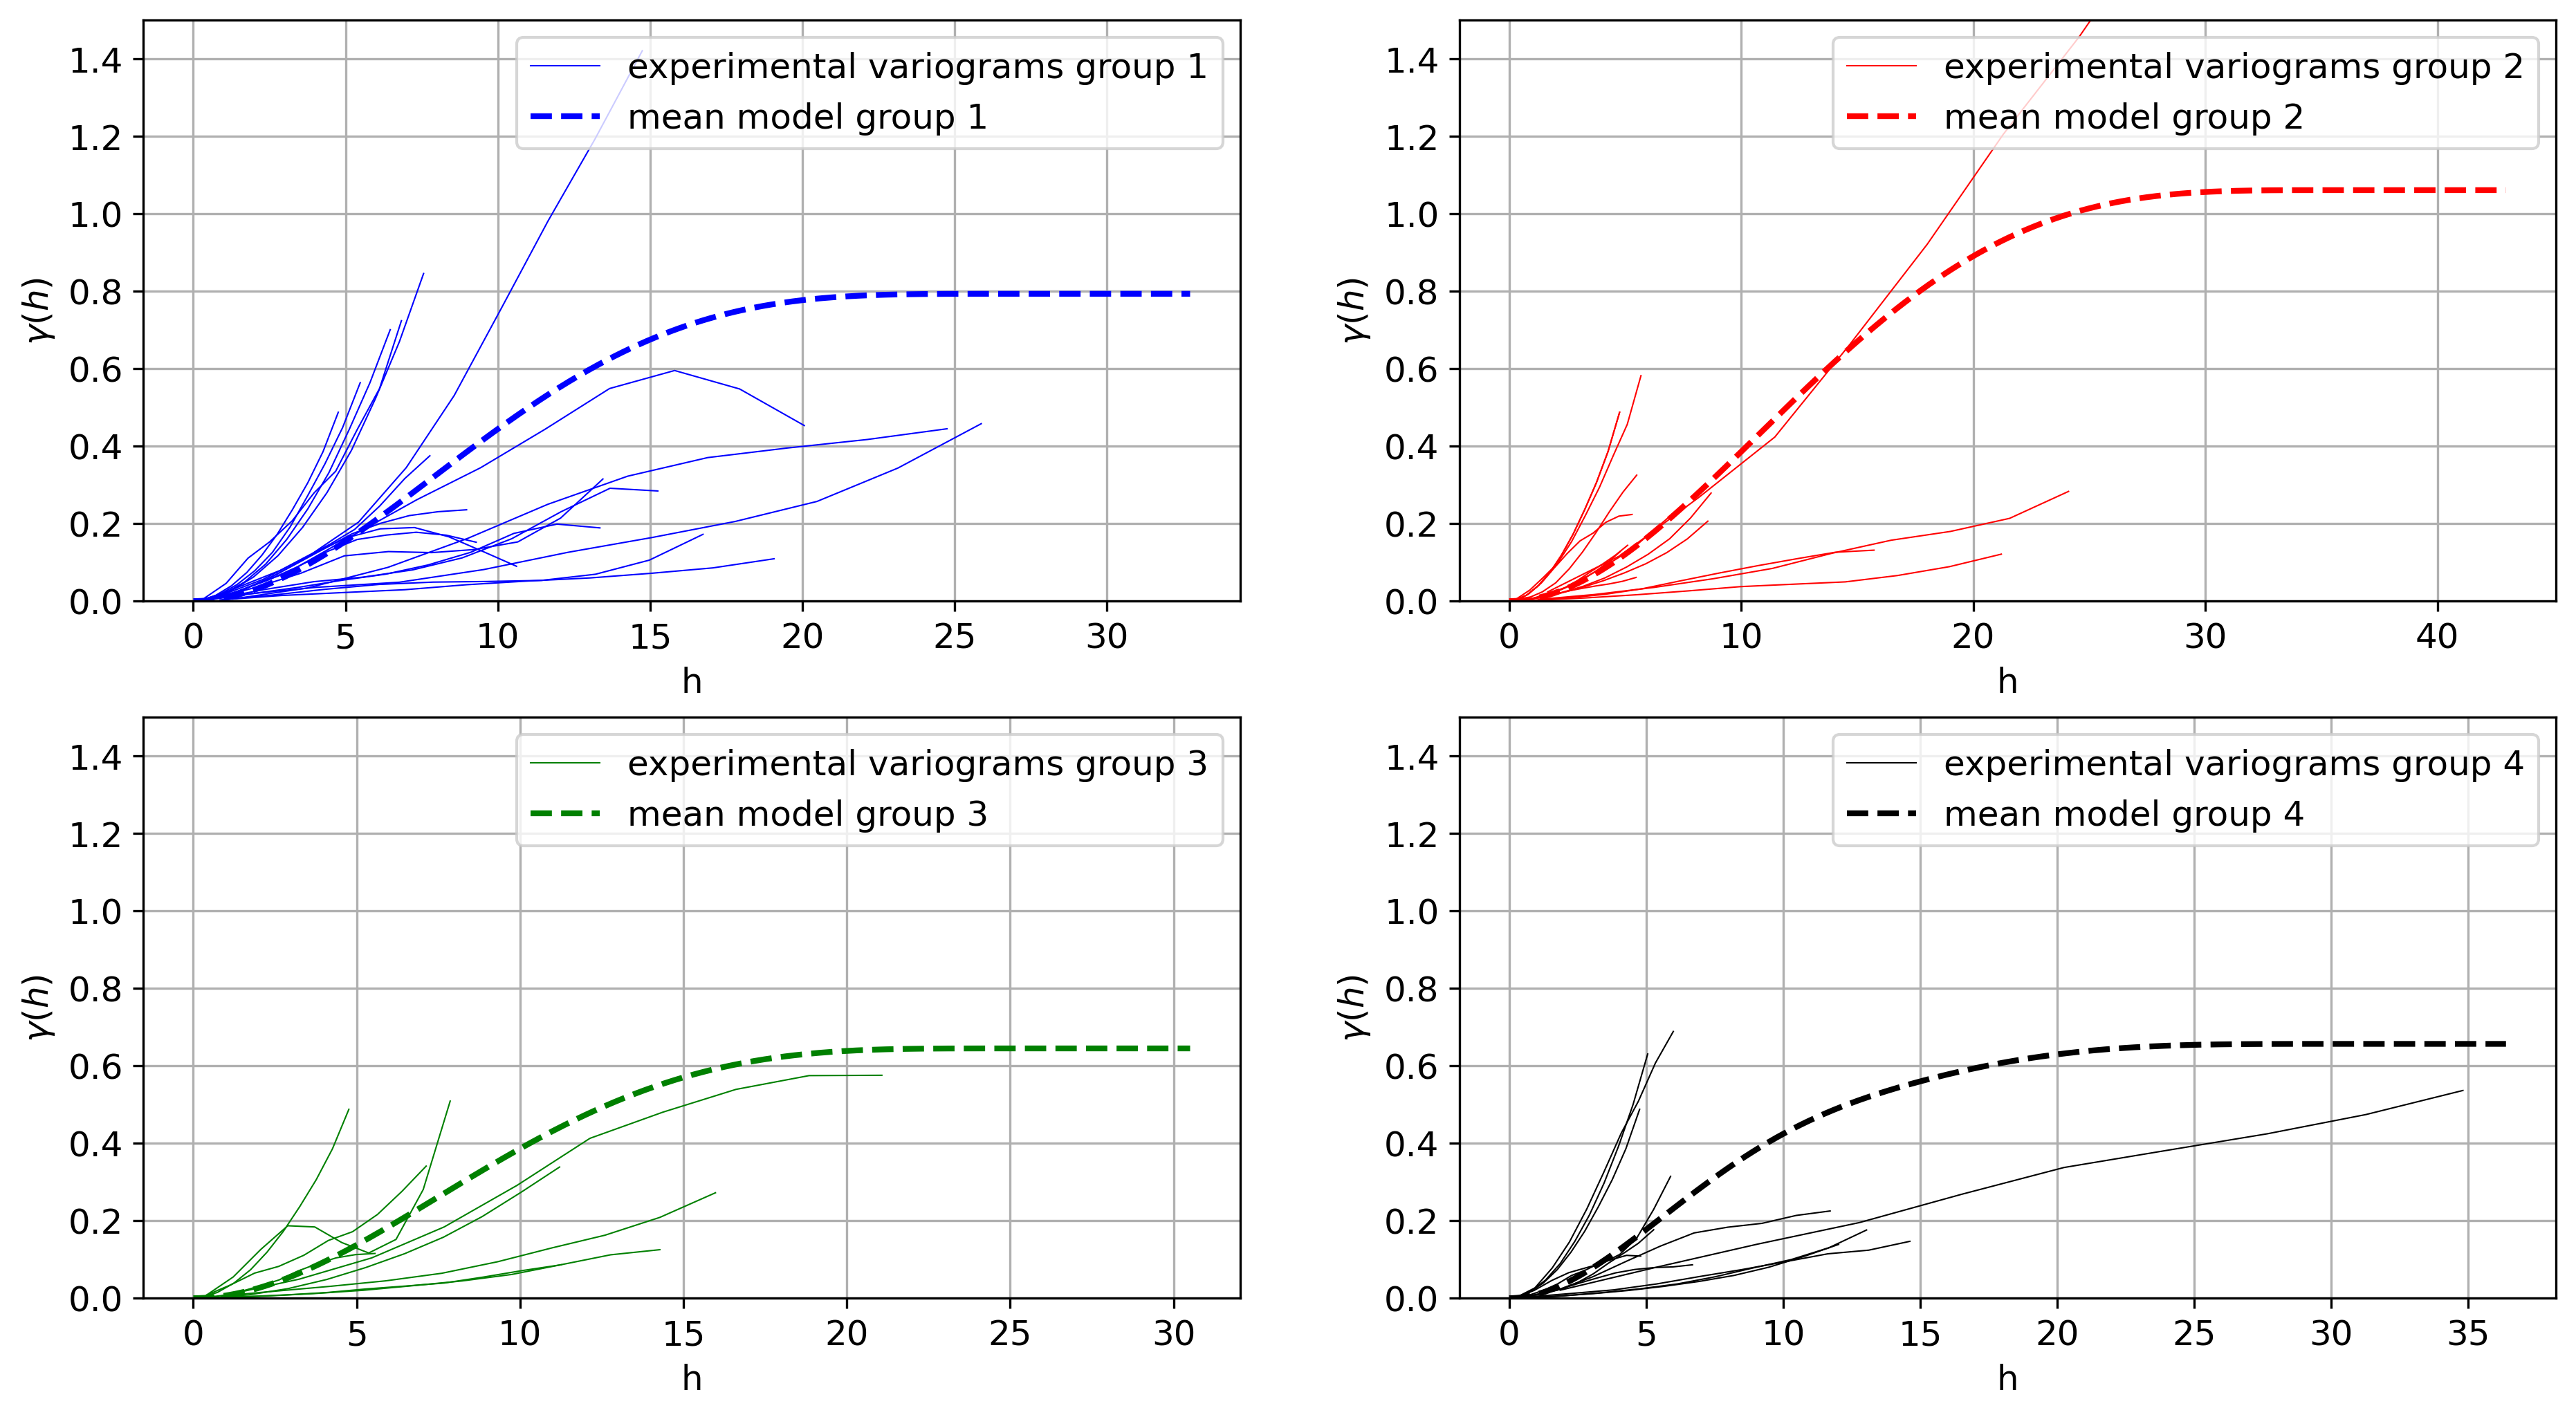

In [56]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 15), dpi=300)

# axes = ax.flatten()
fig = plt.figure(figsize=(15, 8), dpi=300)
colors_list = ["blue", "red", "green", "black", "yellow"]


cm_list_by_group = []
for igroup, c in zip(np.unique(groups), colors_list):
    mask = np.array(groups) == igroup
    
    plt.subplot(2, 2, igroup+1)
    
    for h, v, igroup2 in zip(h_l, v_l, groups):
     
        if igroup2 == igroup:
            plt.plot(h, v, c=c, linewidth=.5)   
            
    plt.plot(h, v, c=c, linewidth=.5, label="experimental variograms group {}".format(igroup + 1))
    
    weights = np.array(h_l)[mask, -1] - np.array(h_l)[mask, 0]
    mean_popt = (weights.reshape(-1, 1) * np.array(popt)[mask]).sum(0) / weights.sum()
    
    
    # cm_mean_popt_igroup = geone.covModel.CovModel1D(elem=[("spherical", {"w":mean_popt[0], "r":mean_popt[1]}),
    #                                          ("cubic", {"w":mean_popt[2], "r":mean_popt[3]}),
    #                                          ("exponential", {"w":mean_popt[4], "r":mean_popt[5]})])
    cm_mean_popt_igroup = geone.covModel.CovModel1D(elem=[("cubic", {"w":0.15+mean_popt[0], "r":mean_popt[1]}),
                                                          ("cubic", {"w":0.15+mean_popt[2], "r":mean_popt[3]})])

    cm_mean_popt_igroup.plot_model(1, c=c, linewidth=2, linestyle="--", label="mean model group {}".format(igroup + 1))  
    cm_list_by_group.append(cm_mean_popt_igroup)
    
    plt.ylim(0, 1.5)
    plt.legend()
#     plt.show()
    
# plt.legend()
cm_list_by_group.append(cm_mean_popt)  # add a covmodel for last group because there was not enough lines to infer a vario

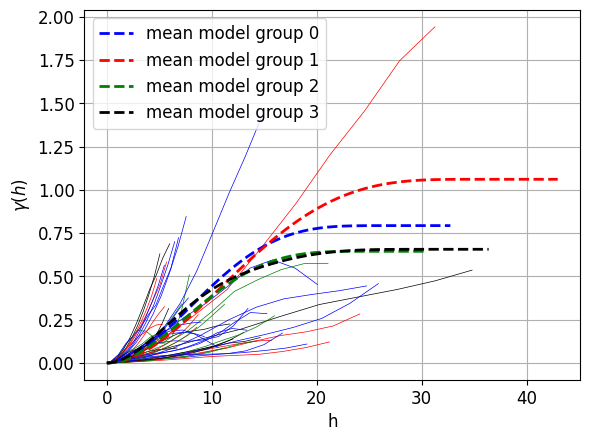

In [57]:
colors_list = ["blue", "red", "green", "black", "yellow"]
for h, v, igroup in zip(h_l, v_l, groups):
    
    if igroup == 0:
        plt.plot(h, v, c="blue", linewidth=.5)
    if igroup == 1:
        plt.plot(h, v, c="red", linewidth=.5)    
    if igroup == 2:
        plt.plot(h, v, c="green", linewidth=.5)   
    if igroup == 3:
        plt.plot(h, v, c="black", linewidth=.5)   

cm_list_by_group = []
for igroup, c in zip(np.unique(groups), colors_list):
    mask = np.array(groups) == igroup


    weights = np.array(h_l)[mask, -1] - np.array(h_l)[mask, 0]
    mean_popt = (weights.reshape(-1, 1) * np.array(popt)[mask]).sum(0) / weights.sum()
    
    cm_mean_popt_igroup = geone.covModel.CovModel1D(elem=[("cubic", {"w":0.15+mean_popt[0], "r":mean_popt[1]}),
                                                          ("cubic", {"w":0.15+mean_popt[2], "r":mean_popt[3]})])

    cm_mean_popt_igroup.plot_model(1, c=c, linewidth=2, linestyle="--", label="mean model group {}".format(igroup))  
    cm_list_by_group.append(cm_mean_popt_igroup)


plt.legend()
cm_list_by_group.append(cm_mean_popt)  # add a covmodel for last group because there was not enough lines to infer a vario

In [58]:
alt = [4.43, 7.22, 10.99, 13.68]
covs = [cm_r4, cm_r5, cm_r4, cm_r4]

sims = []
for i in range(len(alt)):
    
    sim = geone.multiGaussian.multiGaussianRun(covs[i], nx, sx, output_mode="array", mean=alt[i])[0]
    sim[sim > top] = top[sim > top]
    sim[sim < bot] = bot[sim < bot]
    
    for o in range(i):  # erosion rules
        s2 = sims[o]  # older surface
        
        mask = s2 > sim
        s2[mask] = sim[mask]
    sims.append(sim)

In [59]:
def surfs_int(alt, covs, top, bot):
    
    sims = []
    for i in range(len(alt)):

        sim = geone.multiGaussian.multiGaussianRun(covs[i], nx, sx, output_mode="array", mean=alt[i])[0]
        sim[sim > top] = top[sim > top]
        sim[sim < bot] = bot[sim < bot]

        for o in range(i):  # erosion rules
            s2 = sims[o]  # older surface

            mask = s2 > sim
            s2[mask] = sim[mask]
        sims.append(sim)
    
    return sims

In [60]:
def proto_HEROS(ngroups, covmodel_by_groups, proba_by_groups, facies_ids,
                N_by_group, alpha_by_group, xi_by_group,  # EROS params by group
                top, bot, alt, covs,  # intermediate surface params
                nreal=1, seed=None
                 ):
    
    np.random.seed(seed)  # set seed
    
    
    
    all_surfs = []
    all_sims = []
    all_high_surfs = []
    
    for ireal in range(nreal):
        print("sims {}".format(ireal))

        high_surfs = surfs_int(alt, covs, top, bot)  # simulate intermediate levels
        
        surfs = []
        arr_final = np.zeros([nz, nx], dtype=int)
        
        for i in range(ngroups):

            seed = np.random.randint(1e6)

            # EROS params
            if hasattr(N_by_group, "__iter__"):
                N_i = N_by_group[i]
            else:
                N_i = N_by_group
                
            if hasattr(proba_by_groups, "__iter__"):
                proba_i = proba_by_groups[i]
            else:
                proba_i = proba_by_groups

            if hasattr(covmodel_by_groups, "__iter__"):
                covmodel_i = covmodel_by_groups[i]
            else:
                covmodel_i = covmodel_by_groups

            if hasattr(alpha_by_group, "__iter__"):
                alpha_i = alpha_by_group[i]
            else:
                alpha_i = alpha_by_group
                
            if hasattr(xi_by_group, "__iter__"):
                xi_i = xi_by_group[i]
            else:
                xi_i = xi_by_group

            ## intermediate bot/top    
            if i > 0:
                bot_int = high_surfs[i-1]
                min_v = alt[i-1]
            else:
                bot_int = bot
                min_v = np.min(bot)

            if i < len(proba_by_groups) - 1:
                top_int = high_surfs[i]
                max_v = alt[i]
            else:
                top_int = top
                max_v = np.max(top)

        #     top_int[top_int < bot_int] = bot_int[top_int < bot_int]
            height = max_v - min_v

            #means = np.sort(np.random.uniform(min_v - 0.1 * height, max_v + 0.1 * height, size=N_i))
            means = np.linspace(min_v - 0.1 * height, max_v + 0.1 * height, N_i)
            
#             print(means, bot_int, top_int)
            real_surf, arr_res, list_p_cond = EROS.sim_uncond_2D(N_i, covmodel_i, means, (nx, nz), (sx, sz), (0, 0),
                                                                 bot = bot_int, top = top_int, xi = xi_i,
                                                                 proba=proba_i, facies_ids = facies_ids,
                                                                 alpha=alpha_i, seed=seed)

            arr_final[arr_res != -99] = arr_res[arr_res != -99]
            surfs.append(real_surf)
            
        arr_final[arr_final==0] = -99  # set unknown values to -99
        surfs = np.concatenate(surfs)  # concatenate the surfaces
        
        all_surfs.append(surfs)
        all_sims.append(arr_final)
        all_high_surfs.append(high_surfs)
        
    return np.array(all_sims), np.array(all_surfs), all_high_surfs

In [61]:
proba1 = (0.1, 0.5, 0.4)
proba2 = (0.31, 0.32, 0.37)
proba3 = (0.35, 0.2, 0.45)
proba4 = (0.45, 0, 0.45)
proba5 = (0, 0, 1)
probas_all = [proba1, proba2, proba3, proba4, proba5]

Ns = [10, 15, 10, 20, 3]

In [62]:
import EROS

In [63]:
facies_ids

[74, 332, 843]

In [64]:
sims, surfs, high_surfs = proto_HEROS(5, cm_list_by_group, probas_all, facies_ids,
                                      Ns, np.array([0.8, 0.9, 0.9, 0.9, 0.9]), 0.2,
                                      top=top, bot=bot,
                                      alt=alt, covs=covs,
                                      nreal=3, seed=15)

sims 0
sims 1
sims 2


In [65]:
fontsize_axis = 10
fontsize_title = 11

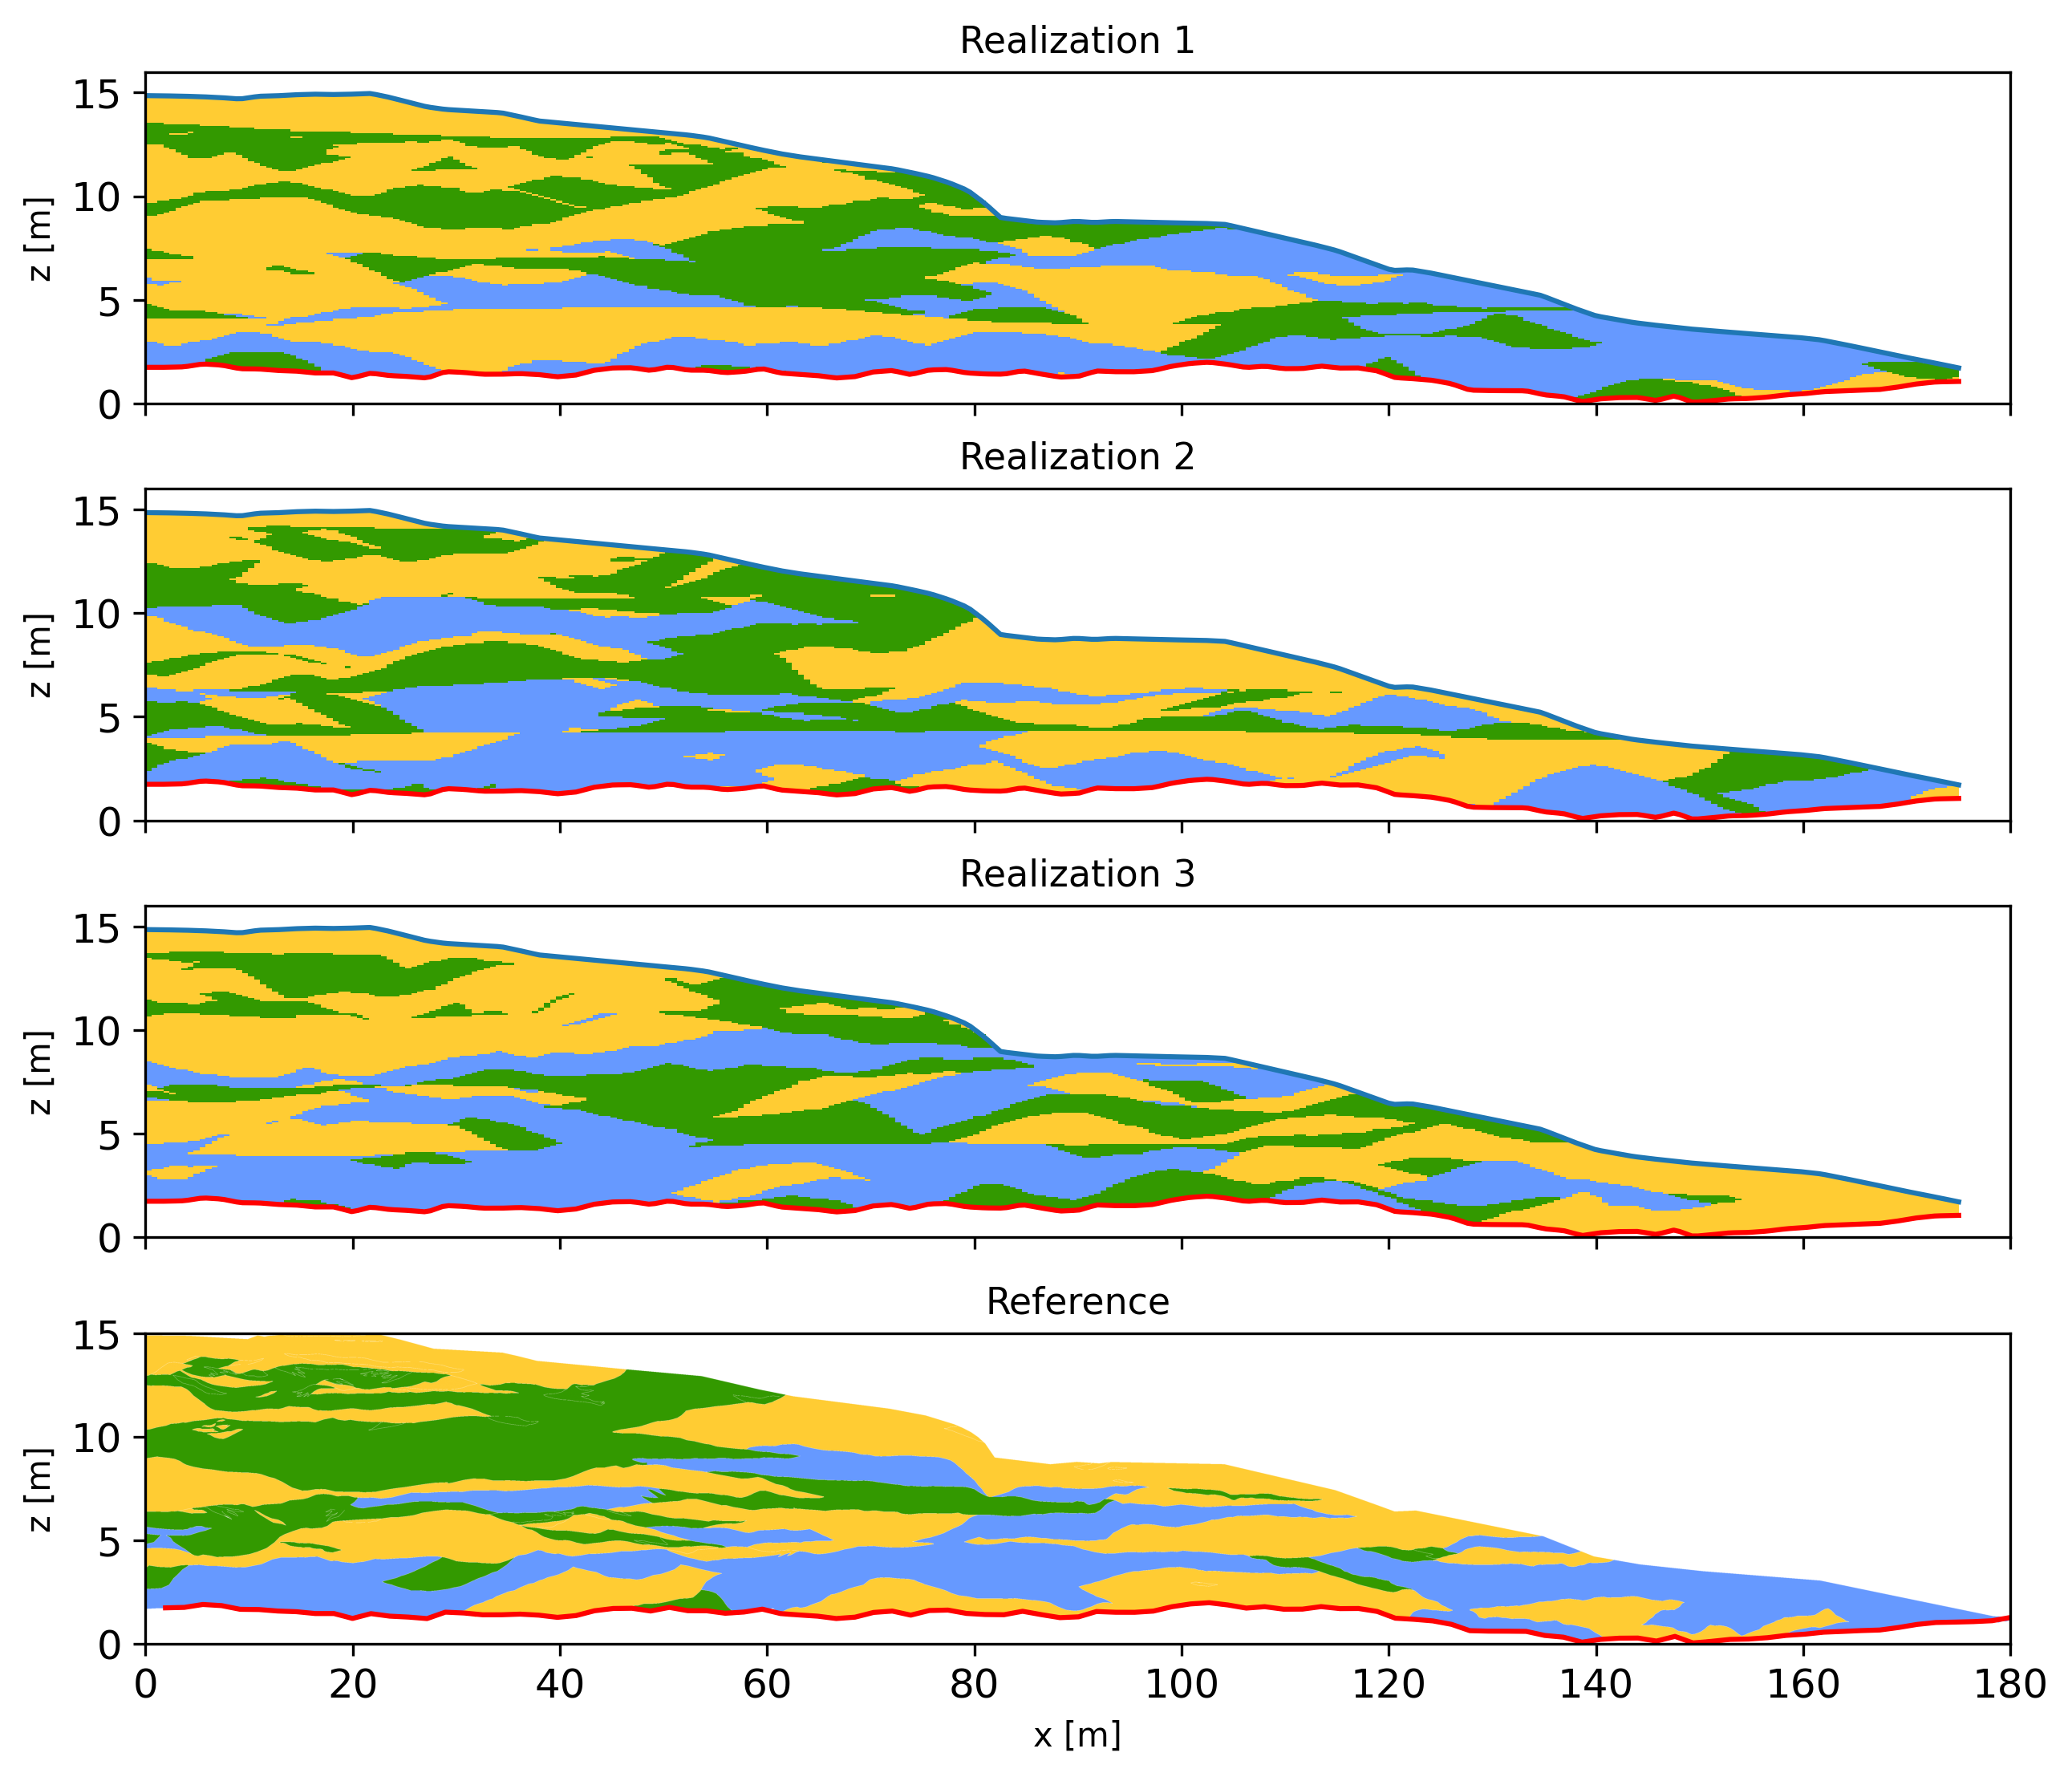

In [66]:
## vizu
fig,ax = plt.subplots(4, 1, figsize=(10, 9), dpi=300, sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(3):
    
    axi = ax[i]
    
    arr_plot = np.zeros([nz, nx, 3])
    arr_final = sims[i]
    real_surf = surfs[i]
    
    o = 0
    for ival in np.unique(arr_final):
        if ival == -99:
            arr_plot[arr_final==-99] = (1, 1, 1)
        else:
            arr_plot[arr_final==ival] = colors[ival][:3]
            o += 1

    axi.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=1, aspect=2)
    axi.set_ylabel("z [m]", fontsize=fontsize_axis)
    axi.set_title("Realization {}".format(i+1), fontsize=fontsize_title)
    axi.plot(xg, top)
    axi.plot(xg, bot, c="r")

axi = ax[-1]

for k,v in dic_surfs.items():
    if k == "Rank_7":
        for test in v:
            axi.plot(test[:, 0], test[:, 1], linewidth=1.5, c=d_color[k])
            
axi.set_xlabel("x [m]", fontsize=fontsize_axis)
axi.set_ylabel("z [m]", fontsize=fontsize_axis)
axi.set_title("Reference", fontsize=fontsize_title)
axi.imshow(arr_plot_ref, extent=[0, 180, 0, 15], aspect=2)

# fig.savefig("../../../figures/articles/EROS/raw_images/application_Bum_NW_nolines.png", bbox_inches='tight')

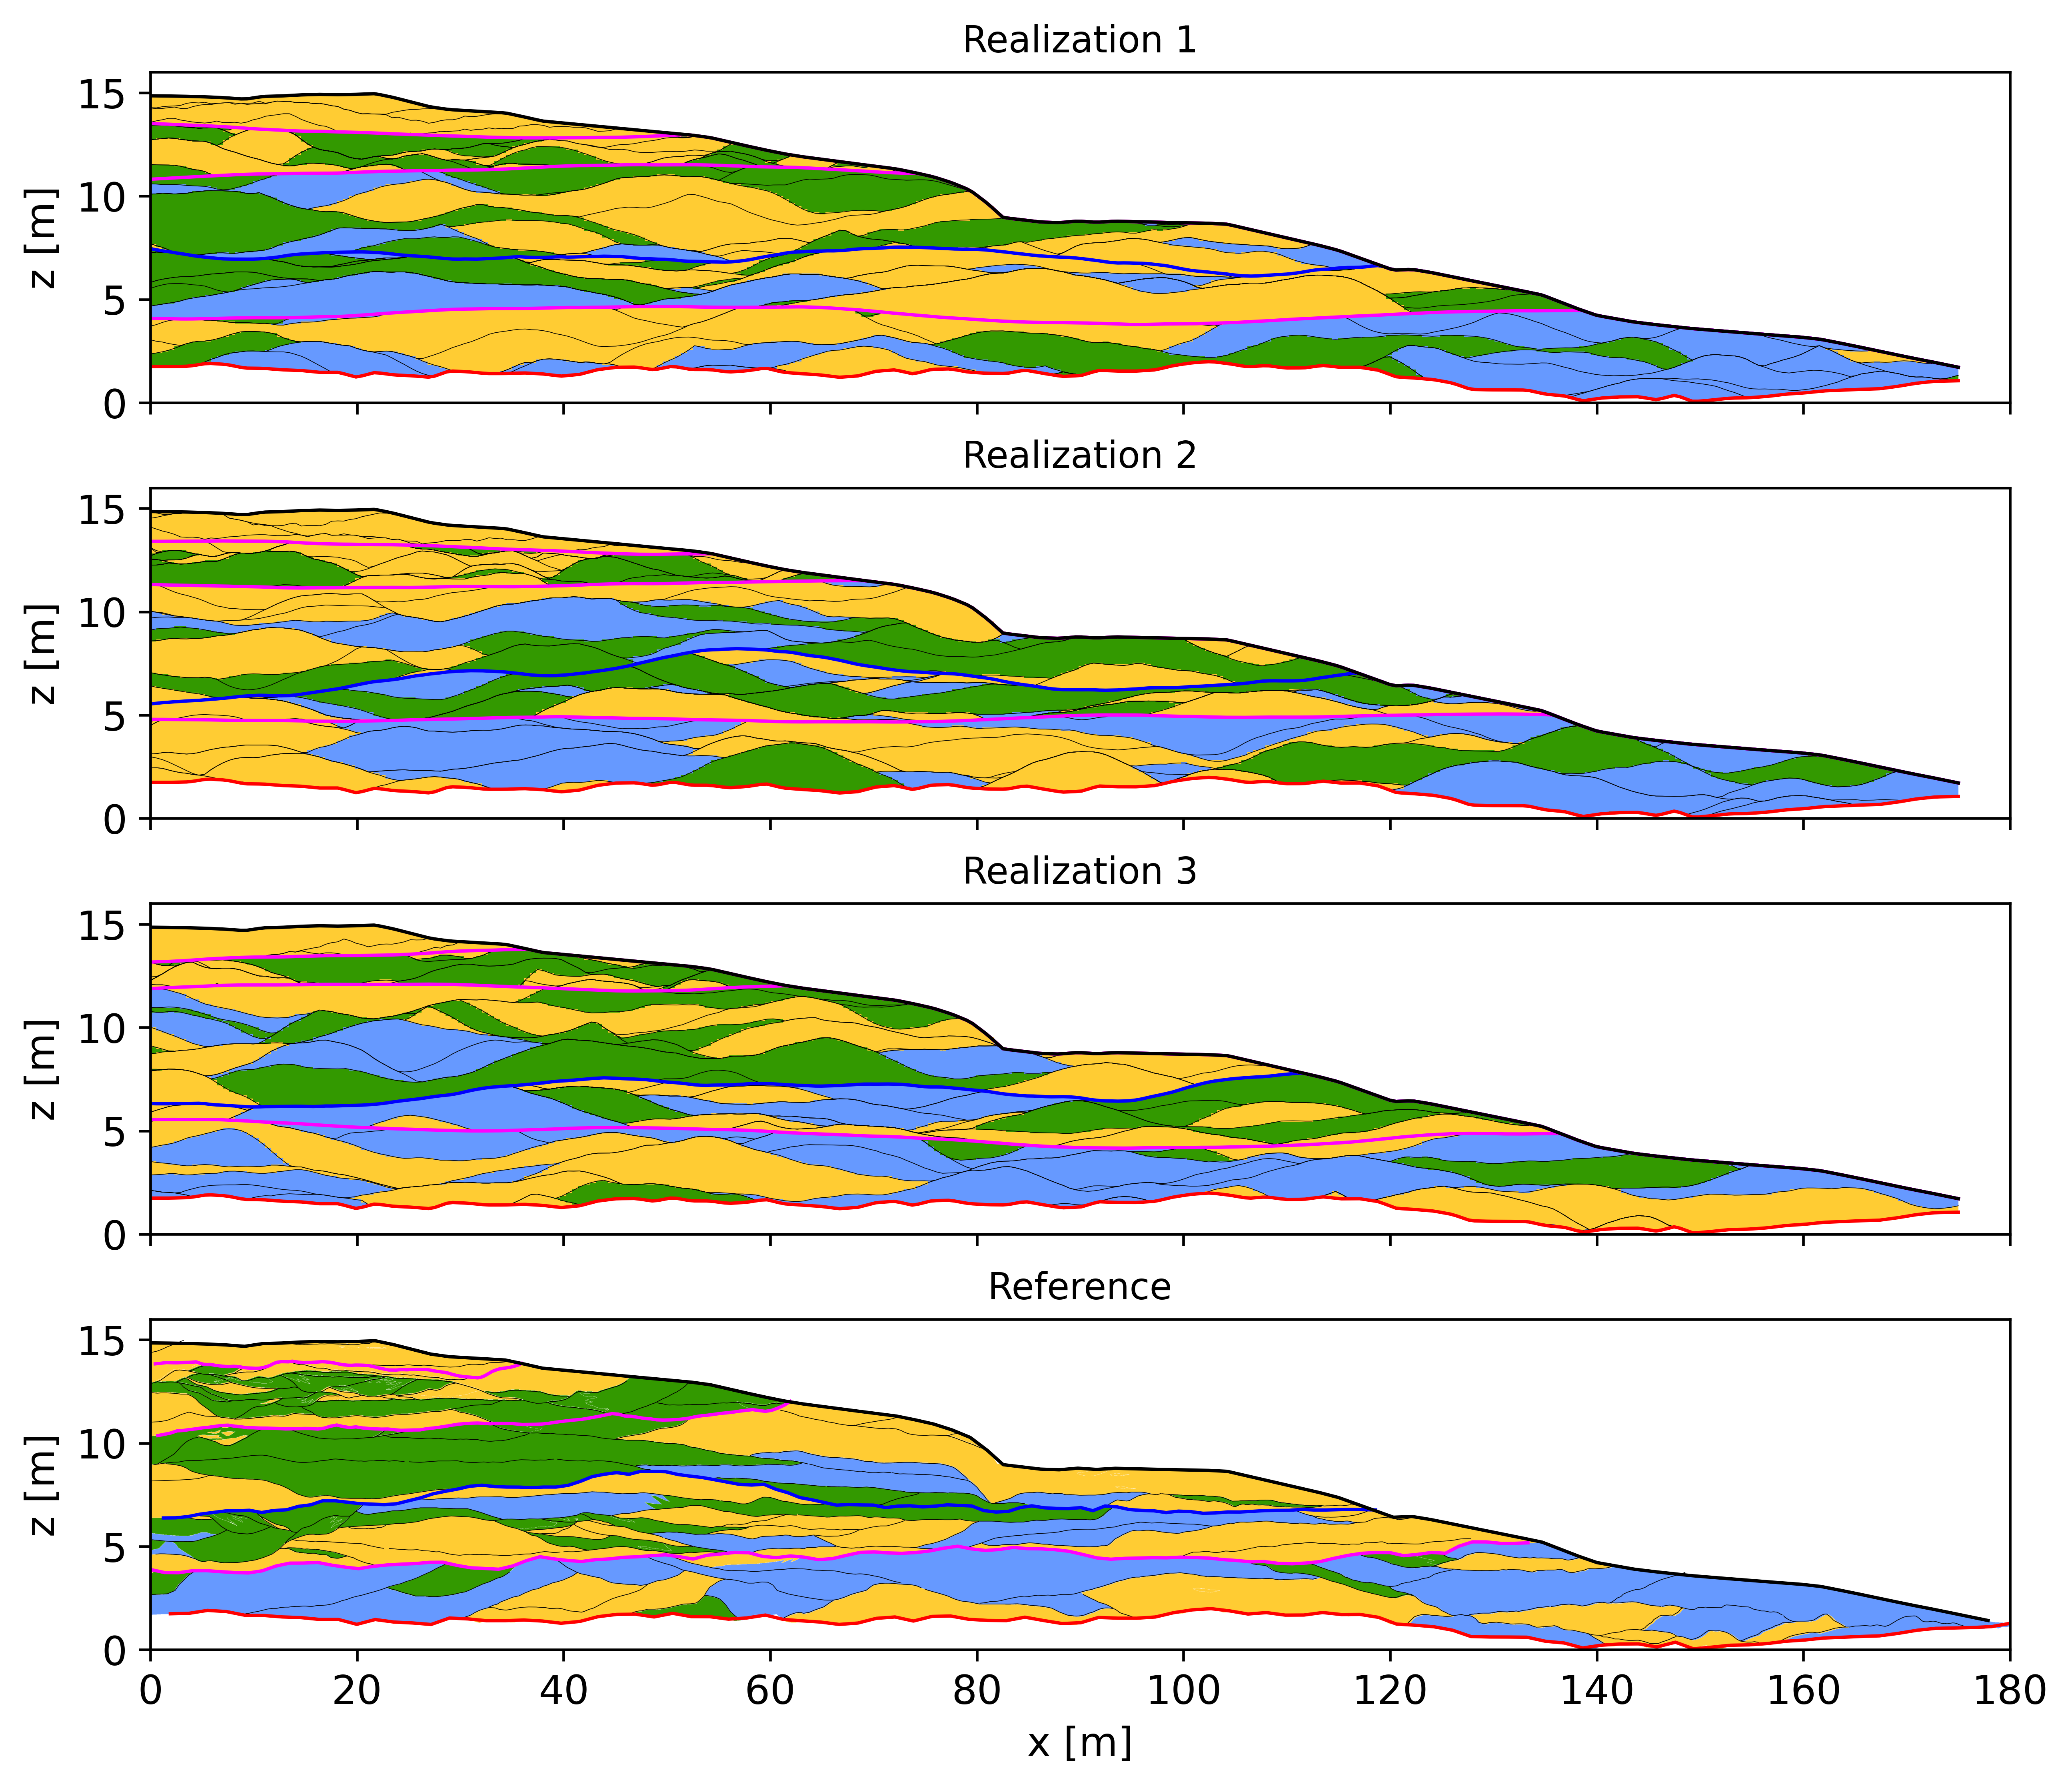

In [71]:
fig,ax = plt.subplots(4, 1, figsize=(10, 9), dpi=600, sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(3):
    
    axi = ax[i]
    
    arr_plot = np.zeros([nz, nx, 3])
    arr_final = sims[i]
    real_surf = surfs[i]
    
    
    o = 0
    for ival in np.unique(arr_final):
        if ival == -99:
            arr_plot[arr_final==-99] = (1, 1, 1)
        else:
            arr_plot[arr_final==ival] = colors[ival][:3]
            o += 1

    axi.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=1, aspect=2)
    axi.set_ylabel("z [m]")
    axi.set_title("Realization {}".format(i+1), fontsize=fontsize_title)
    axi.plot(xg, real_surf.T, c="k", linewidth=.2)
    c_hs = ["fuchsia", "blue", "fuchsia", "fuchsia"]
    o = 0
    for s in high_surfs[i]:
        axi.plot(xg, s, c=c_hs[o], linewidth=1)
        o += 1
    axi.plot(xg, top, linewidth=1, c="k")
    axi.plot(xg, bot, c="r", linewidth=1)
    
axi = ax[-1]
for k,v in dic_surfs.items():
    if k == "Rank_3":
        for test in v:
            axi.plot(test[:, 0], test[:, 1], linewidth=.2, c="k")
    else:
        for test in v:
            axi.plot(test[:, 0], test[:, 1], linewidth=1, c=d_color[k])

axi.set_xlabel("x [m]")
axi.set_ylabel("z [m]")
axi.set_title("Reference", fontsize=fontsize_title)
axi.imshow(arr_plot_ref, extent=[0, 180, 0, 15], aspect=2)
axi.set_ylim(0, 16)

# fig.savefig("../../../figures/articles/EROS/raw_images/application_Bum_NW.png", bbox_inches='tight')

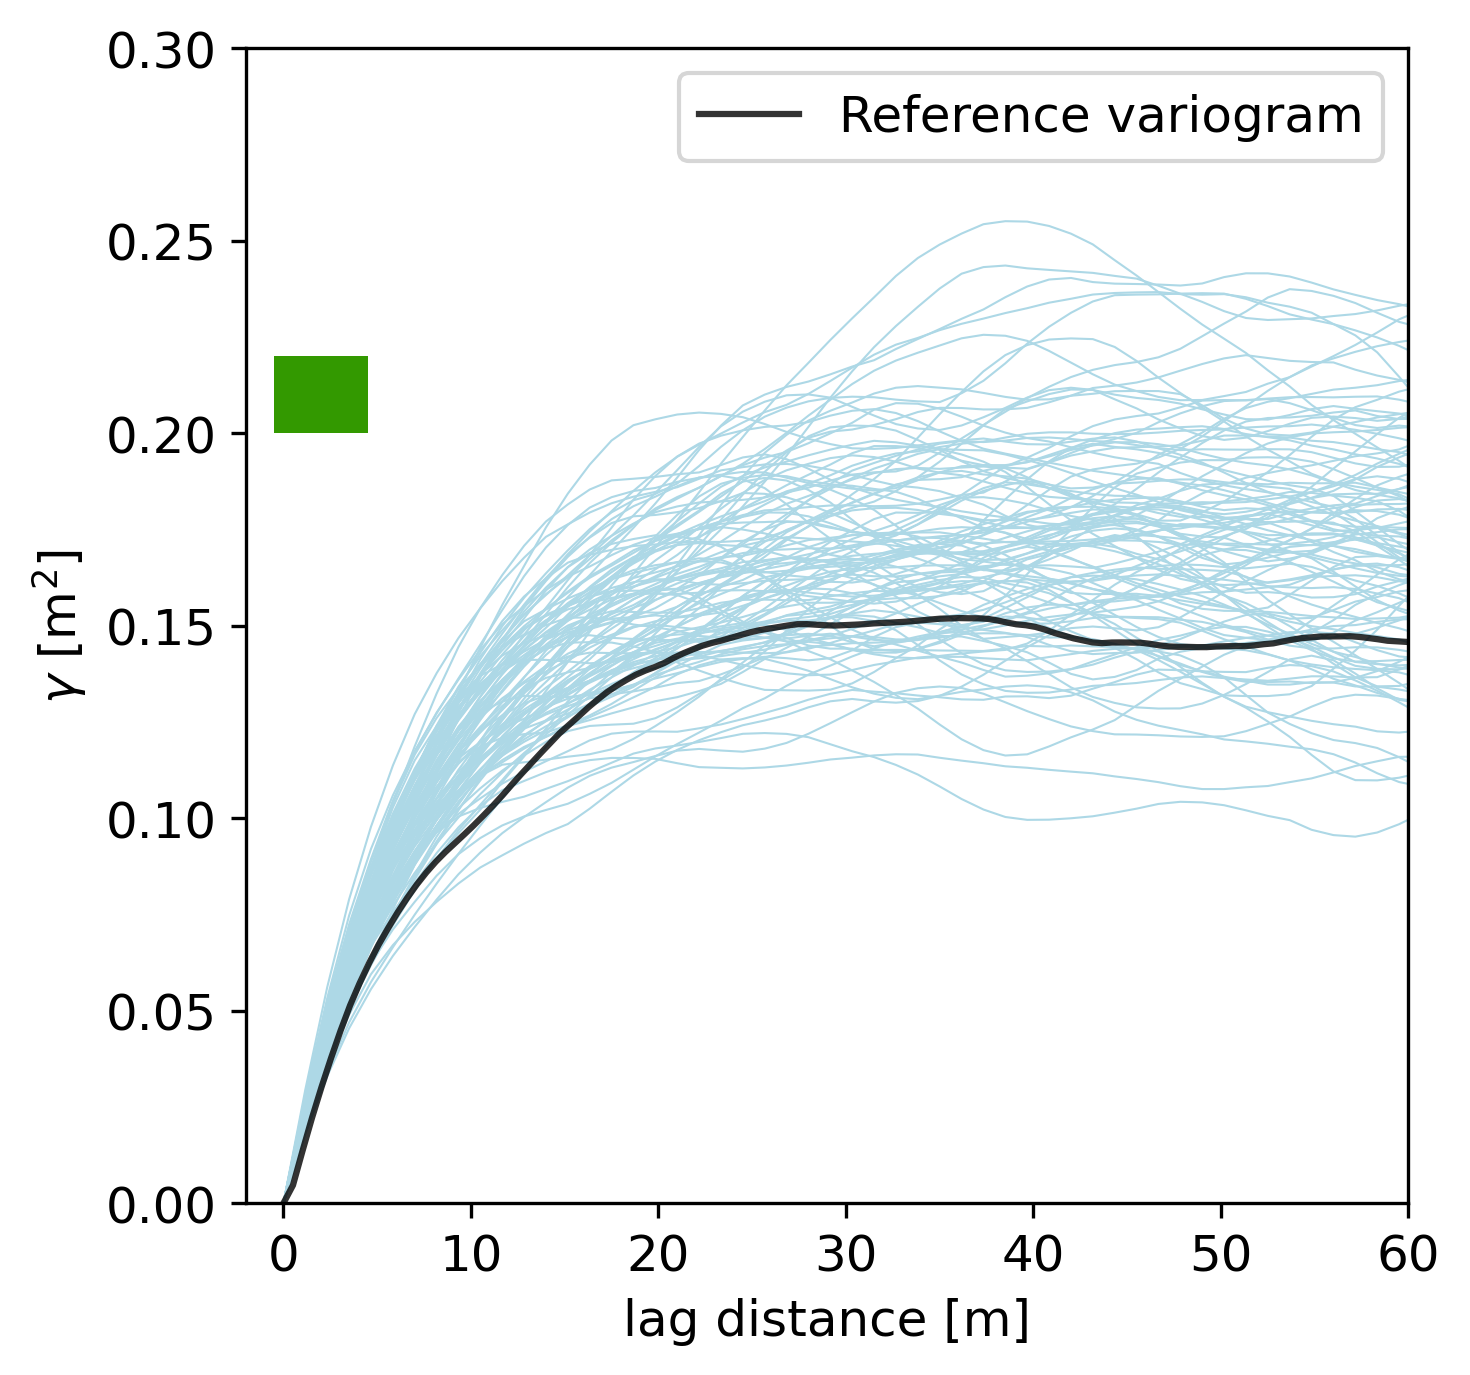

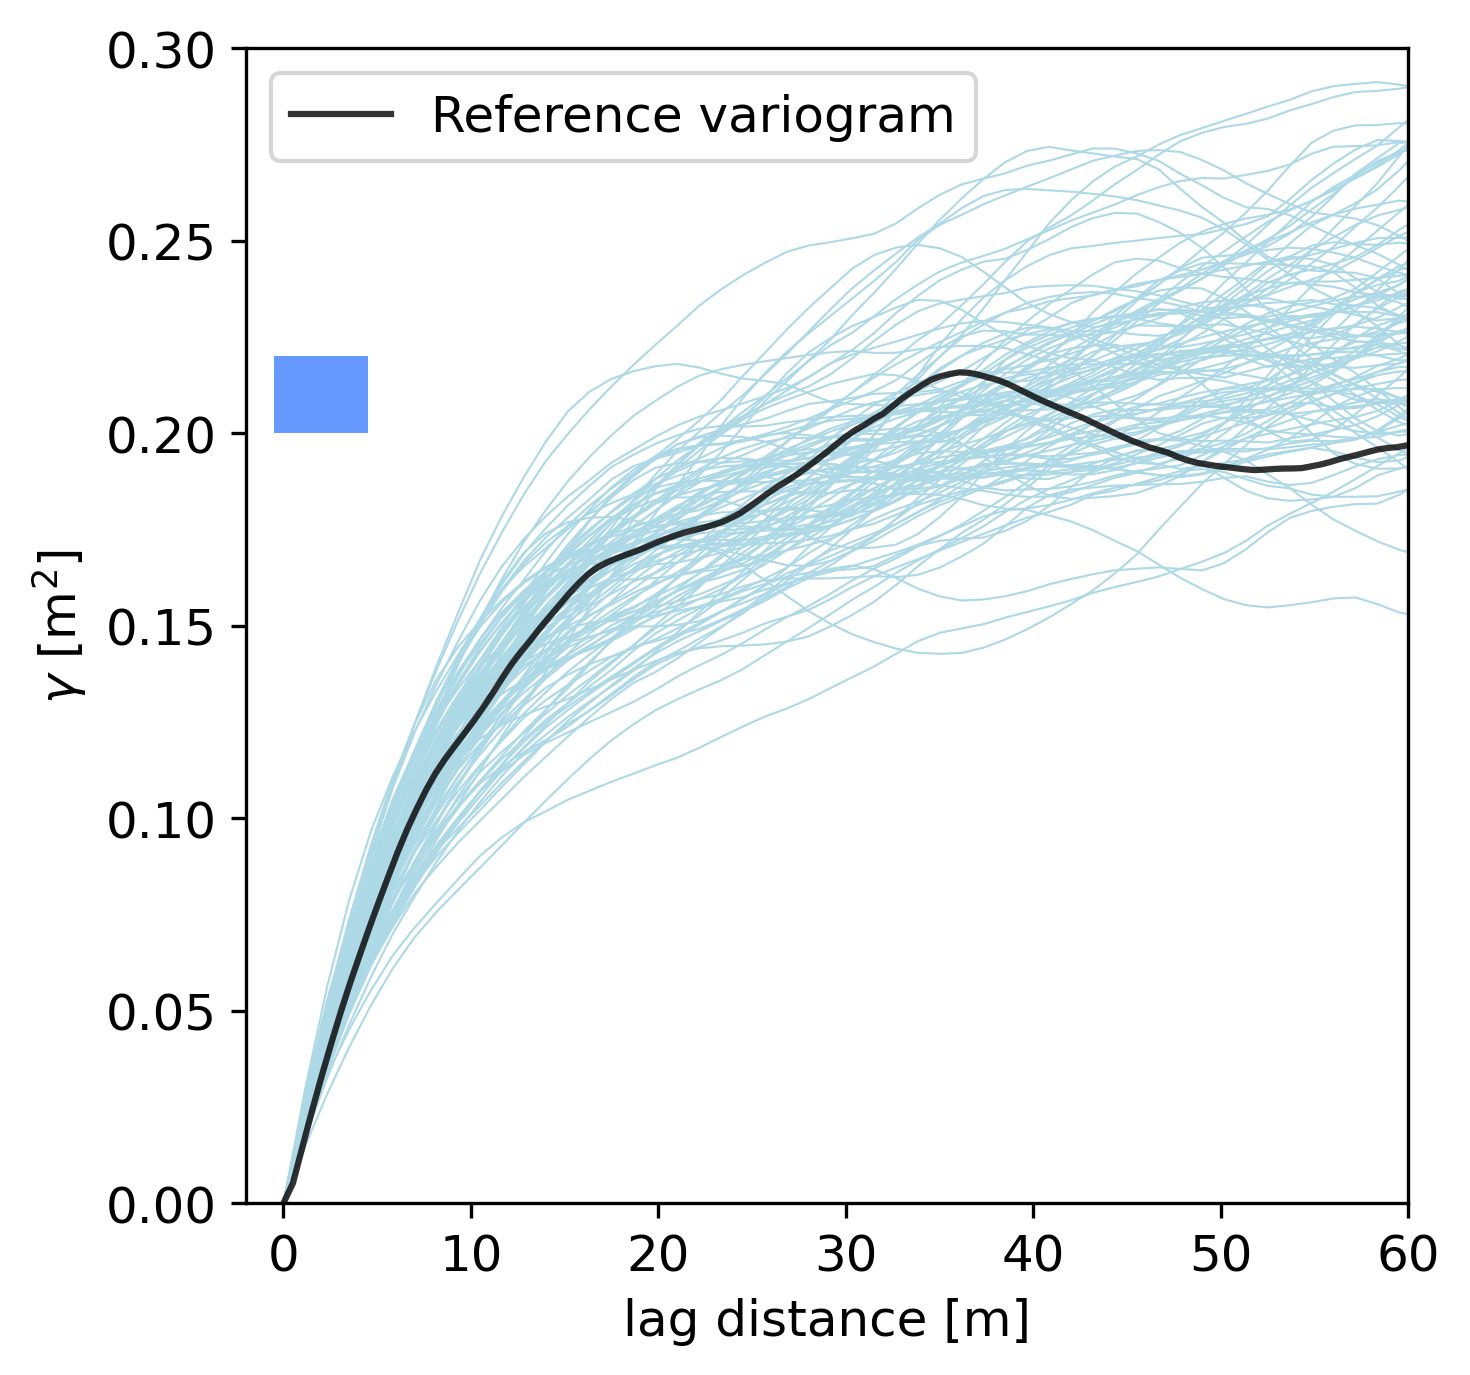

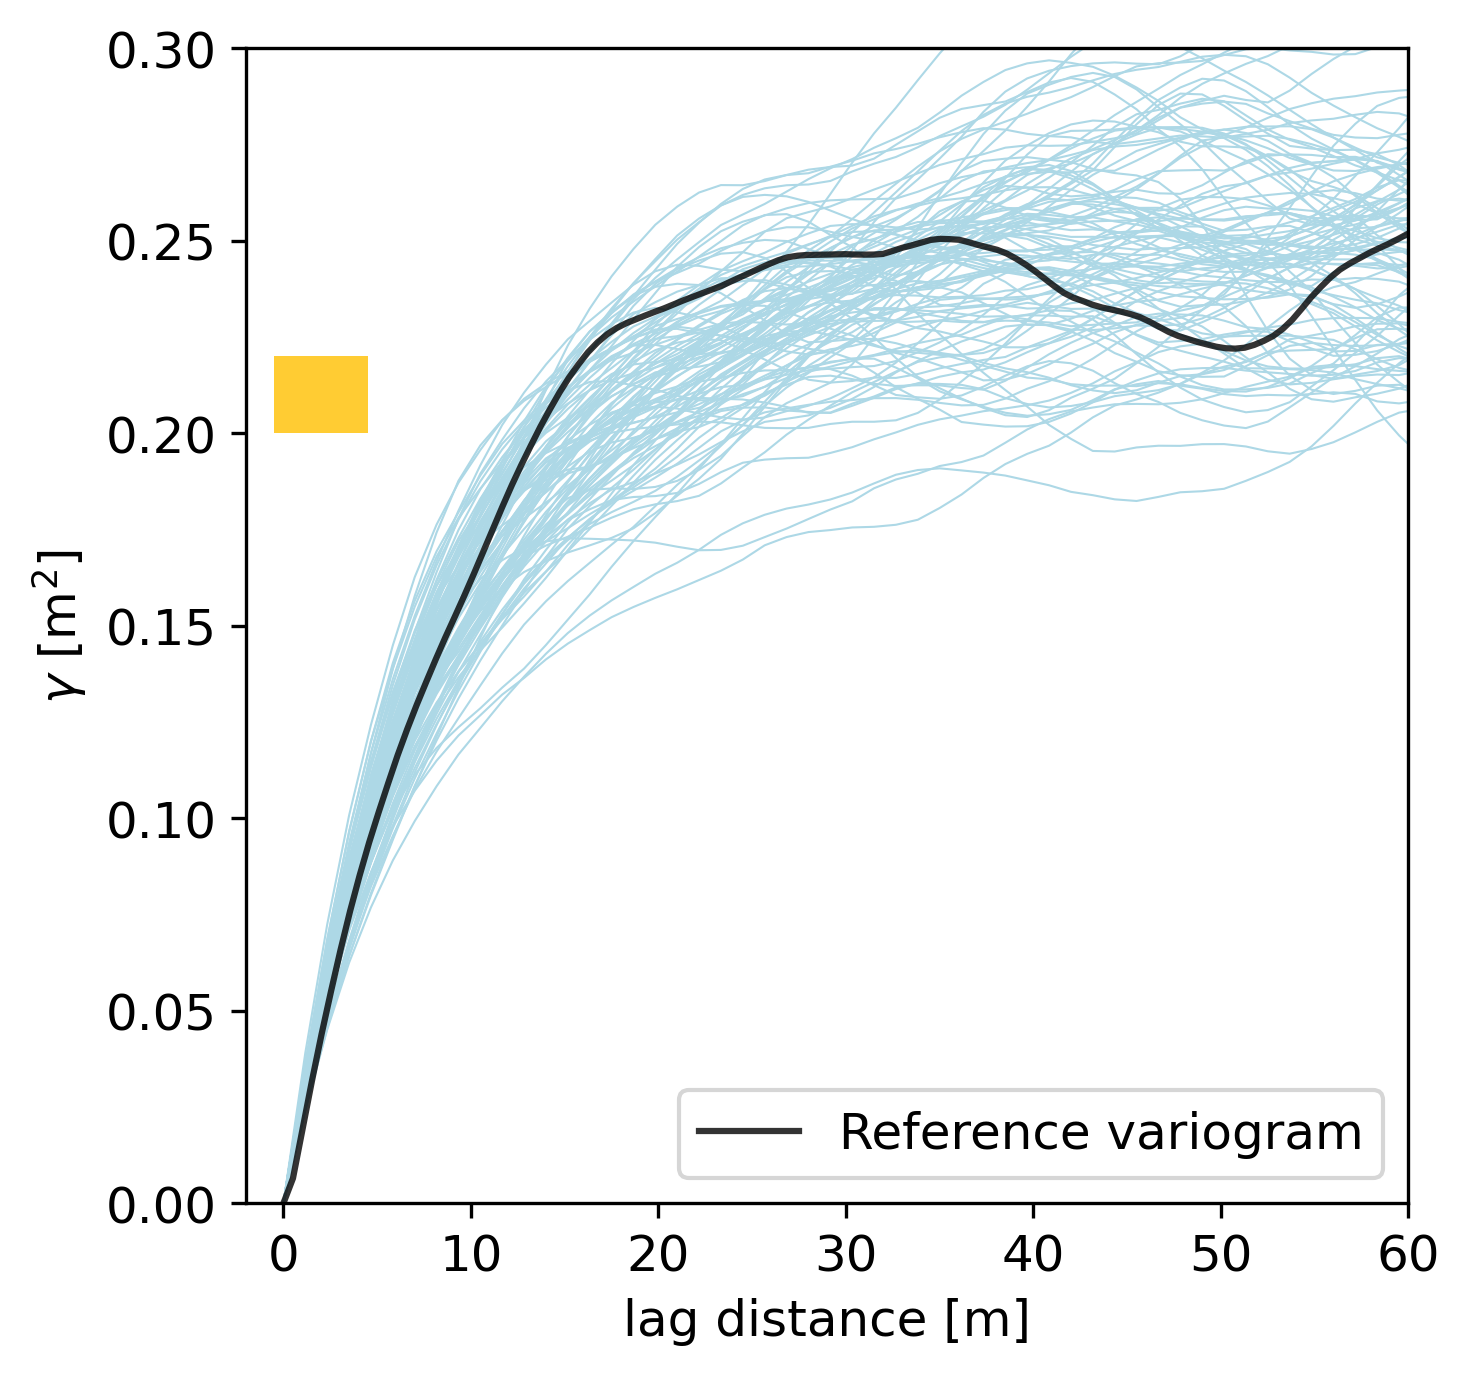

In [107]:
for i, facies_id in enumerate(facies_ids[:]):

    fig = plt.figure(figsize=(5, 5), dpi=300)

    # compute variograms on realizations
    for isim in sims:

        val = isim.astype(float).copy()

        val[val != facies_id] = 0
        val[val == facies_id] = 1

        val[isim == -99] = np.nan

        im_sim = geone.img.Img(nx=nx, ny=nz, nz=1, nv=1, val=val, sx=sx, sy=sz, sz=1, ox=ox, oy=oz, oz=0)

        im_sim_1_cov = geone.geosclassicinterface.imgTwoPointStatisticsImage(im_sim, 0, hx_min=-110, hx_max=110, hy_min=-50, hy_max=50, hx_step=2, hy_step=2, stat_type="variogram")

        x = im_sim_1_cov.sx * np.arange(int(im_sim_1_cov.nx/2 + 1))
        y = im_sim_1_cov.sy * np.arange(int(im_sim_1_cov.ny/2 + 1))
        # plt.subplot(2, 2, i+1)
        plt.plot(x, im_sim_1_cov.val[0, 0, int(im_sim_1_cov.ny/2), int(im_sim_1_cov.nx/2):], c="lightblue", linewidth=.5)

        # plot a rectangle of the color of the facies
        color = colors[facies_id]
        plt.bar(2, .02, bottom=0.2, color=color, width=5)

        # plt.title("Facies {}".format(facies_id))

    plt.plot(varios_hor[i][0][:-18], varios_hor[i][1][:-18], c="k", alpha=0.8, label="Reference variogram")
    plt.legend()

    plt.ylim(0, 0.3)
    plt.xlim(-2, 60)

    plt.xlabel("lag distance [m]")
    plt.ylabel(r"$\gamma$ [m$^2$]")

    # plt.show()
    # plt.savefig("../../../figures/articles/EROS/raw_images/Bum_NS_variogram_facies_{}.png".format(facies_id), bbox_inches='tight')
    # plt.close()

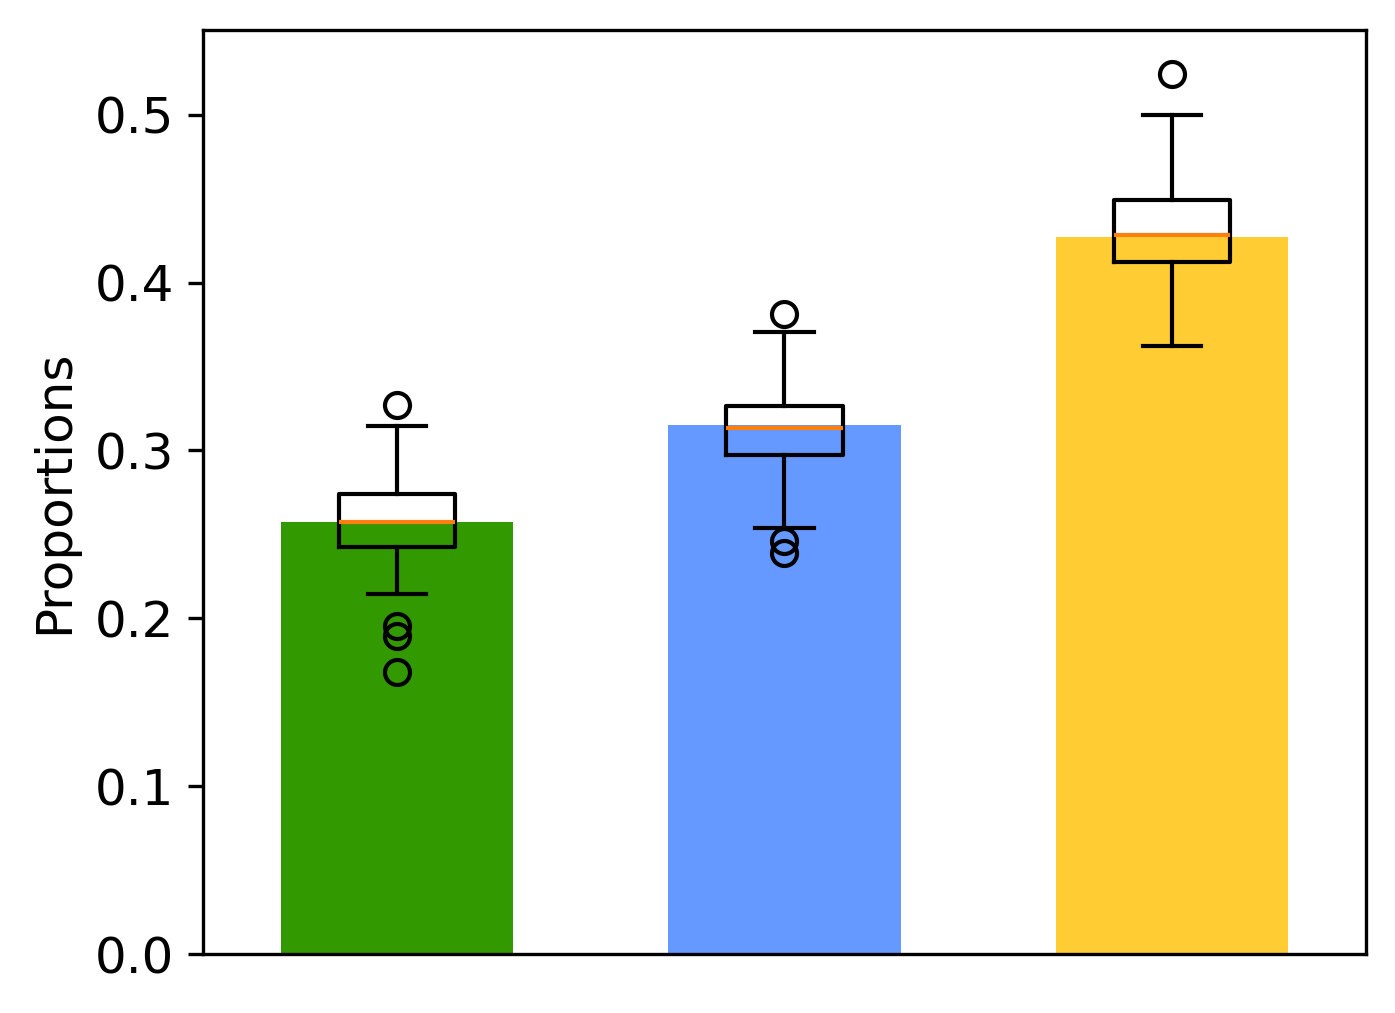

In [103]:
# analyze proportions in realizations
total_counts = []

for isim in sims:

    val = isim.astype(float).copy()
    ids, counts = np.unique(val, return_counts=True)
    counts = counts[1:]
    ids = ids[1:]
    counts = counts / counts.sum()
    total_counts.append(counts)

total_counts = np.array(total_counts)
# plot
plt.figure(figsize=(5, 4), dpi=300)

# plot reference proportions
proba_ref = probas.copy()

for i in range(0, len(colors)):
    color = colors[ids[i]]
    plt.bar(i+1, proba_ref[i], bottom=0, color=color, width=.6, alpha=1, label="Ref. prop {}".format(i+1))
    
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# box plot of proportions

plt.boxplot(total_counts, showfliers=True)
plt.ylabel("Proportions")
plt.xticks([])

# plt.savefig("../../../figures/articles/EROS/raw_images/Bum_NS_proportions.png", bbox_inches='tight')


In [105]:
import pickle
with open("cm_params_NS.pkl", "wb") as f:
    pickle.dump(cm_list_by_group, f)

In [129]:
with open("NS_top.pkl", "wb") as f:
    pickle.dump(np.array((xg, top)), f)

with open("NS_bot.pkl", "wb") as f:
    pickle.dump(np.array((xg, bot)), f)